# **Clustering using KMeans, Agglomerative, and Birch Clustering**

In [1]:
# Import Package yang dibutuhkan
import numpy as np 
import pandas as pd 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, Birch, MeanShift, KMeans, DBSCAN, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('data.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Ukuran dataset
df.shape

(2240, 29)

In [4]:
# Mengecek null value
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Hanya ada sedikit data yang null, maka bisa kita drop

In [5]:
df.dropna(inplace=True)

In [6]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

## **Feature Engineering**

Kolom Education

In [7]:
df['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [8]:
# Kita sederhanakan menjadi 3 kategori, yaitu undergraduate, graduate, dan postgraduate
df['Education'] = df['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

Kolom Marital Status

In [9]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [10]:
# Kita sederhanakan menjadi 2 kategori, yaitu single dan not single
df['Marital_Status'] = df['Marital_Status'].replace({'YOLO':'Single', 'Alone':'Single', 'Absurd':'Single', 'Widow':'Single', 'Divorced':'Single', 'Together':'Not Single', 'Married':'Not Single'})

Kolom Dt_Customer

In [11]:
df['Dt_Customer'].value_counts()

31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: Dt_Customer, Length: 662, dtype: int64

In [12]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

C:\Users\Nando\AppData\Local\Temp\ipykernel_32672\177162232.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


Membuat kolom yang merepresentasikan seberapa lama seseorang sudah menjadi pengguna produk ini

In [13]:
df['days_since_registration'] = (datetime.today() - df['Dt_Customer']).dt.days

In [14]:
df.drop(columns=['Dt_Customer'], inplace=True)

Membuat kolom Age berdasarkan tahun lahir seseorang

In [15]:
df['Age'] = 2023 - df['Year_Birth']

In [16]:
df.drop(['Year_Birth'], axis=1, inplace=True)

Membuat kolom Total_Children berdasarkan jumlah anak dari kolom Kidhome dan Teenhome

In [17]:
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

In [18]:
df.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

In [19]:
# df['Parent'] = df['Total_Children'].apply(lambda x: 1 if x > 0 else 0)

Membuat kolom Total_Spent yang merepresentasikan jumlah uang yang dihabiskan oleh seseorang

In [20]:
df['Total_Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Membuat kolom Total_Purchase yang merepresentasikan jumlah produk yang dibeli oleh seseorang

In [21]:
df['Total_Purchase'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

Membuang kolom yang isinya sama semua dan 100% unique

In [22]:
df['Z_CostContact'].value_counts()

3    2216
Name: Z_CostContact, dtype: int64

In [23]:
df['Z_Revenue'].value_counts()

11    2216
Name: Z_Revenue, dtype: int64

In [24]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [25]:
df.drop(['ID'], axis=1, inplace=True)

Hapus kolom yang tidak diperlukan

In [26]:
delete_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']
df = df.drop(delete_cols, axis=1)

In [27]:
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,days_since_registration,Age,Total_Children,Total_Spent,Total_Purchase
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,4117,66,0,1617,25
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,3271,69,2,27,6
2,Graduate,Not Single,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,3618,58,0,776,21
3,Graduate,Not Single,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,3211,39,1,53,8
4,Postgraduate,Not Single,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,3467,42,1,422,19


Membuang Outlier

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

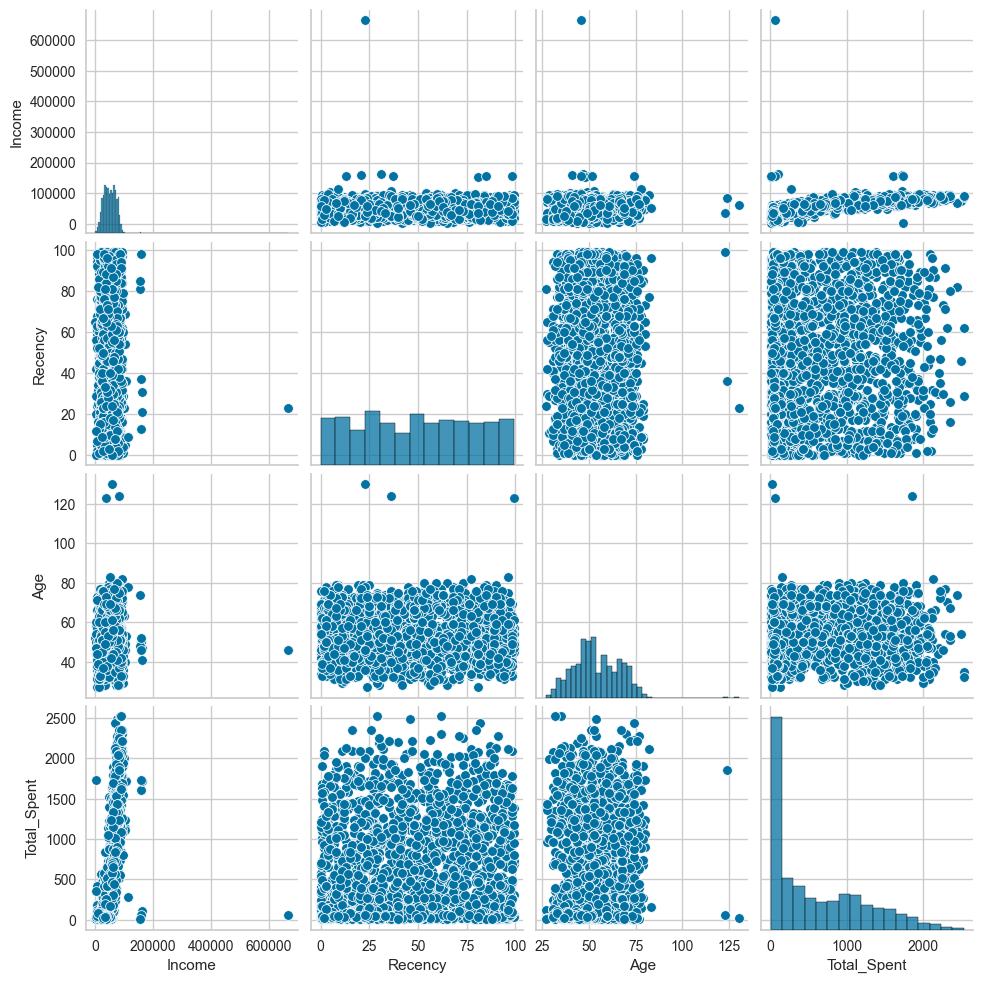

In [28]:
plot = ["Income", "Recency", "Age", "Total_Spent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[plot])
plt.show()

Tampak ada outlier pada kolom Income dan Age

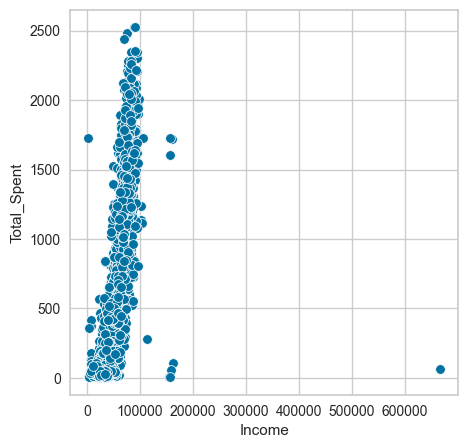

In [29]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Income', y='Total_Spent', data=df)
plt.show()

Ada outlier pada kolom Income

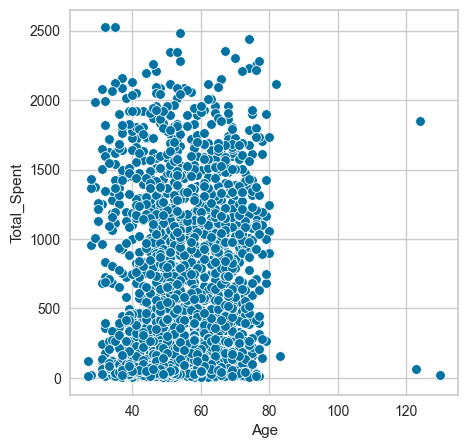

In [30]:
# scatterplot
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Age', y='Total_Spent', data=df)
plt.show()

Ada outlier pada kolom Age

Membuang outlier tersebut

In [31]:
df = df[df['Age'] < 100]
df = df[df['Income'] < 600000]

## **Data Preprocessing**
Encode kolom yang memiliki tipe data object

In [32]:
encode = ['Education', 'Marital_Status']

In [33]:
# encode dengan label encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for item in encode:
    df[item] = le.fit_transform(df[item])

Scaling menggunakan standard scaler

In [34]:
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)

In [35]:
df_scaled.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,days_since_registration,Age,Total_Children,Total_Spent,Total_Purchase
0,-0.893586,1.349603,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.018352,-1.264598,1.676245,1.317945
1,-0.893586,1.349603,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,1.404572,-0.963297,-1.159273
2,-0.893586,-0.740959,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.334530,-1.264598,0.280110,0.796425
3,-0.893586,-0.740959,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,0.069987,-0.920135,-0.898513
4,0.571657,-0.740959,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-1.033114,0.069987,-0.307562,0.535666


#### **Dimensionality Reduction dengan PCA**

In [36]:
# Ubah menjadi 3 dimensi
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_pca = pd.DataFrame(pca.transform(df_scaled), columns=['PC1', 'PC2', 'PC3'])

In [37]:
df_pca

,PC1,PC2,PC3
0,4.552179,0.858973,2.019538
1,-2.788319,-0.835734,-2.092540
2,2.105108,-0.202769,-0.382557
3,-2.741626,-1.203441,-0.315357
4,-0.004648,0.522411,-0.087656
...,...,...,...
2207,2.840227,0.928009,0.779825
2208,-0.954299,3.300508,-3.413918
2209,1.743947,-0.744274,0.152798
2210,2.099061,0.198308,-1.667700


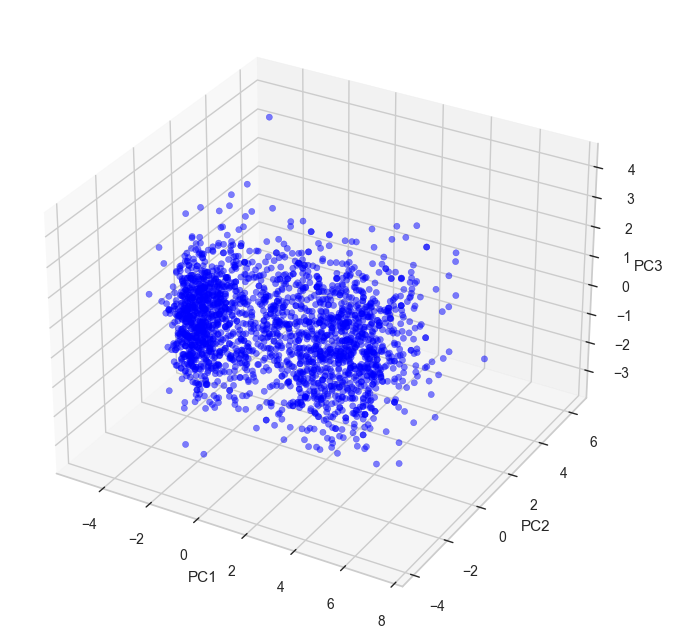

In [38]:
x = df_pca['PC1']
y = df_pca['PC2']
z = df_pca['PC3']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

Mencari jumlah cluster paling optimal untuk KMeans

Elbow Method untuk mencari jumlah cluster optimal:


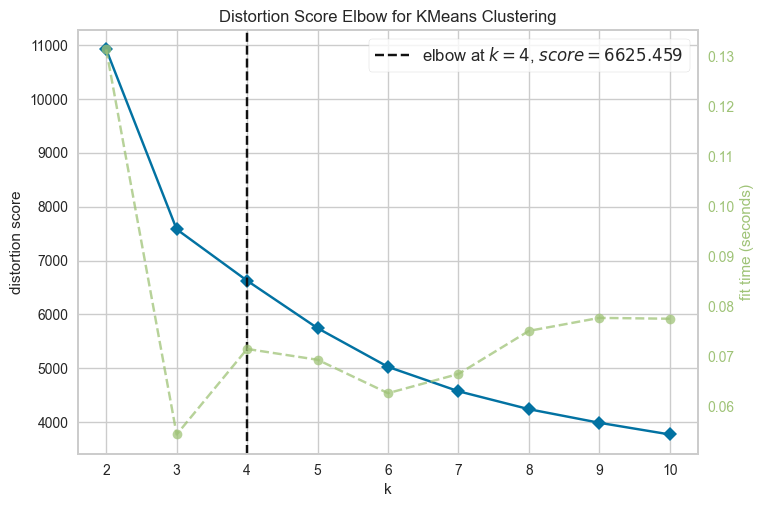

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
print('Elbow Method untuk mencari jumlah cluster optimal:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_pca)
Elbow_M.show()

Artinya, 4 cluster adalah jumlah cluster paling optimal

## **Model Clustering**
### **KMeans Clustering**

In [40]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans = kmeans.fit_predict(df_pca)

df['Cluster'] = kmeans

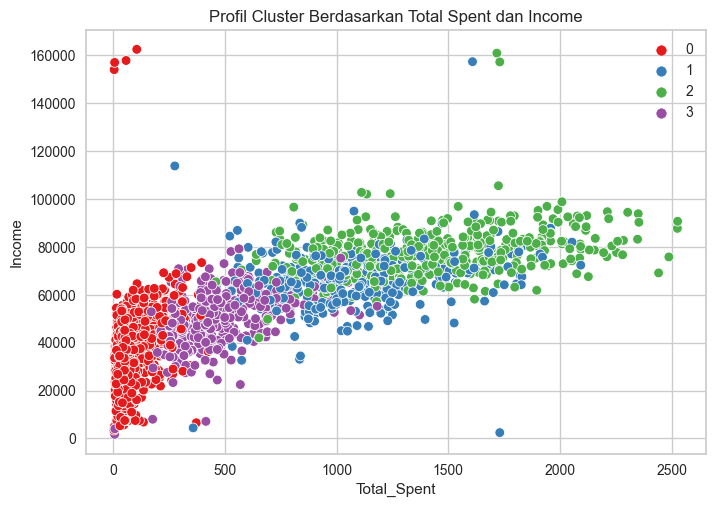

In [41]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

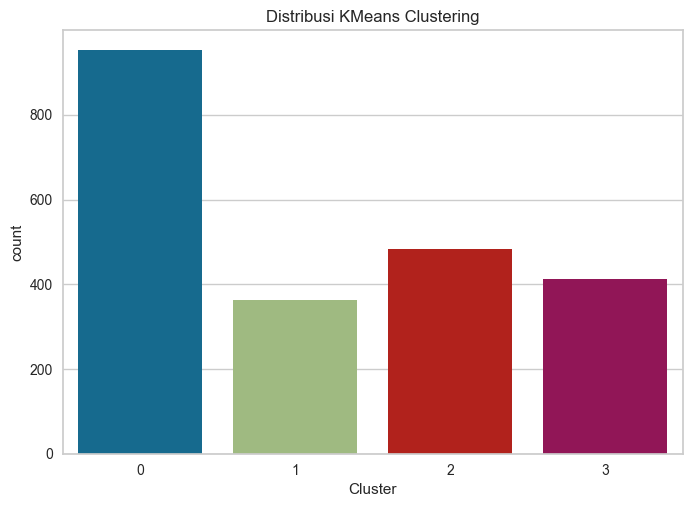

In [42]:
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi KMeans Clustering")
plt.show()

c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  

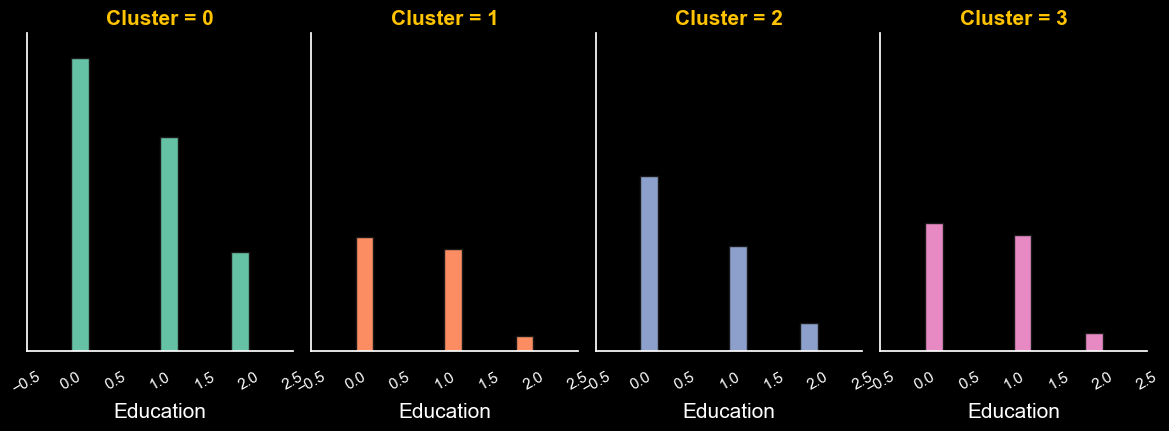

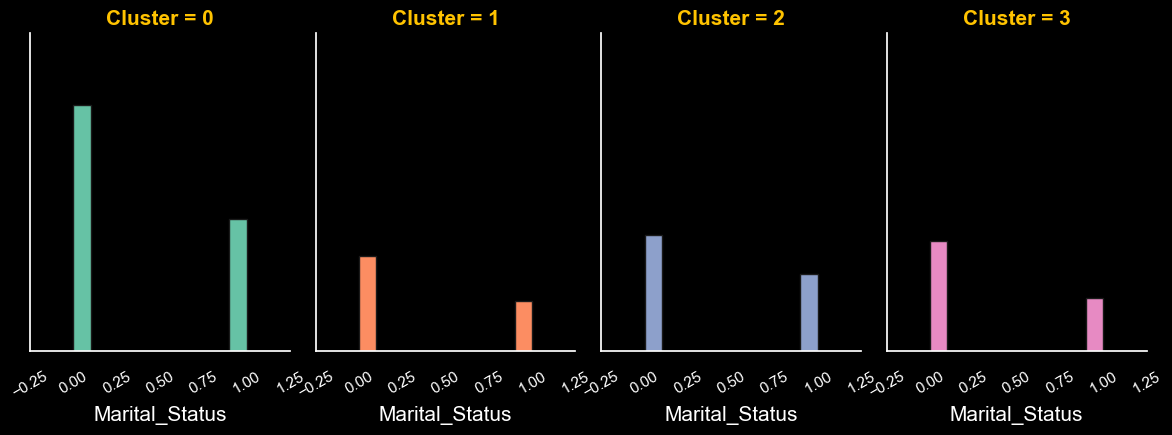

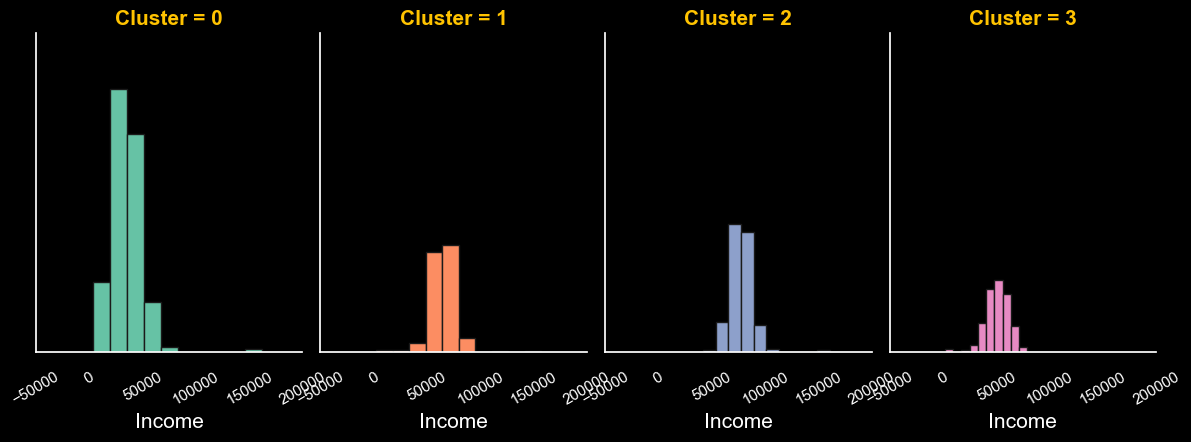

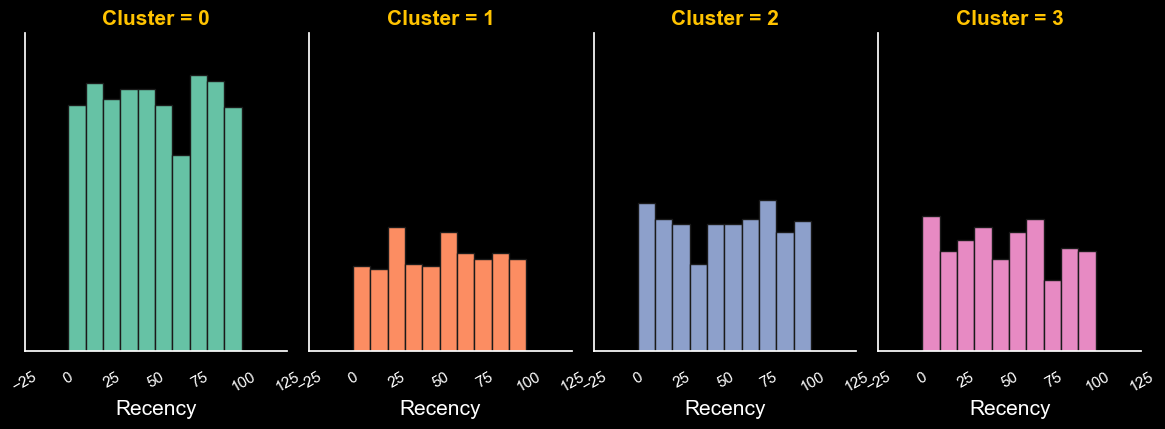

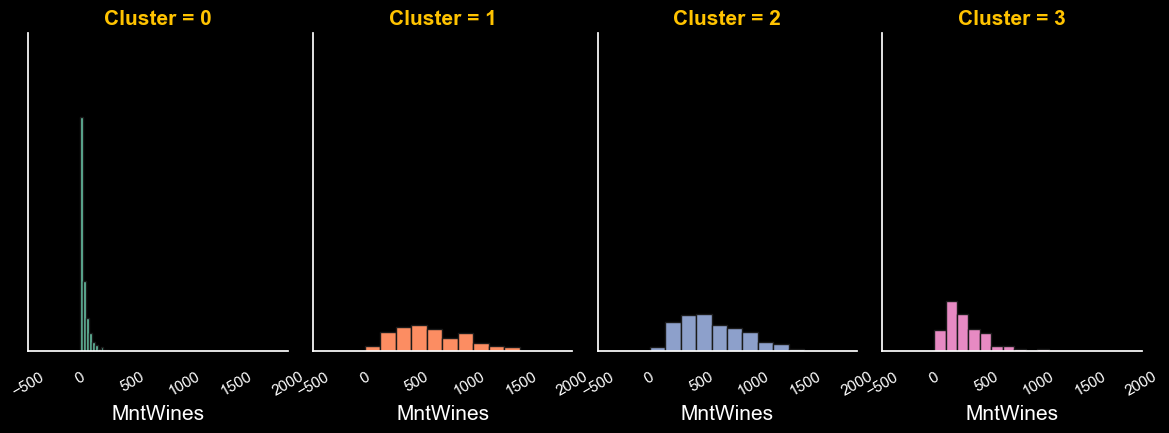

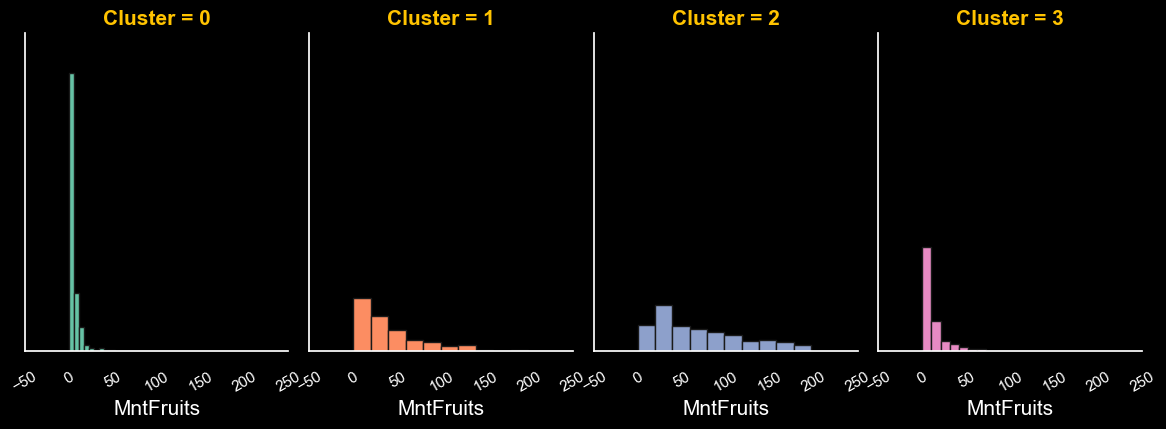

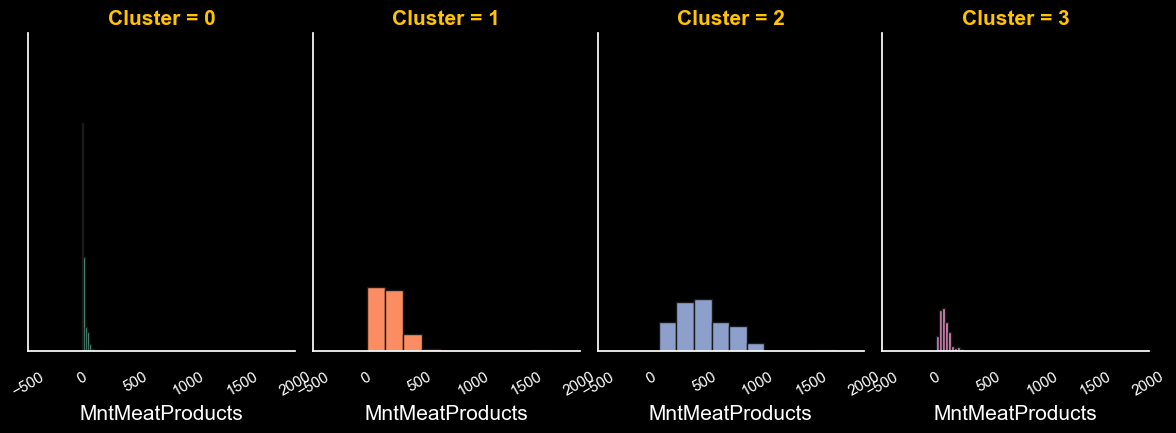

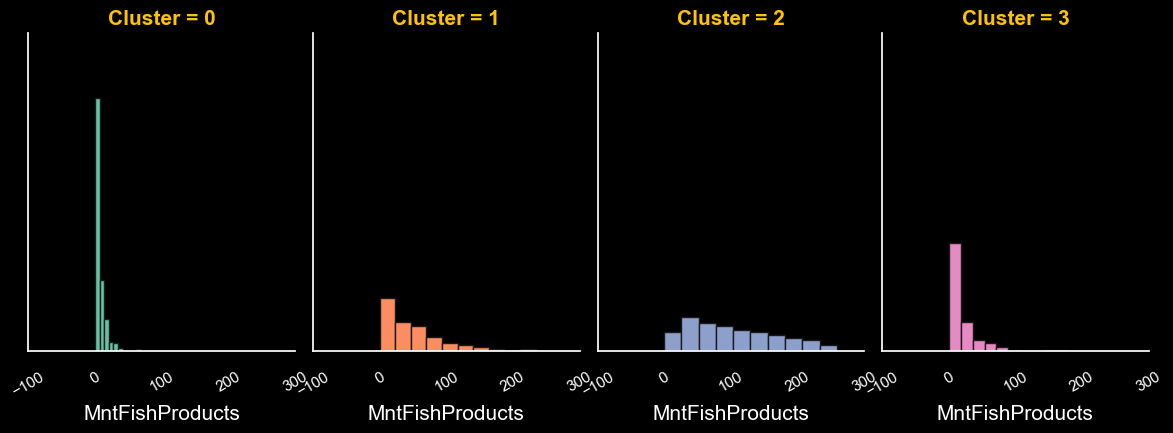

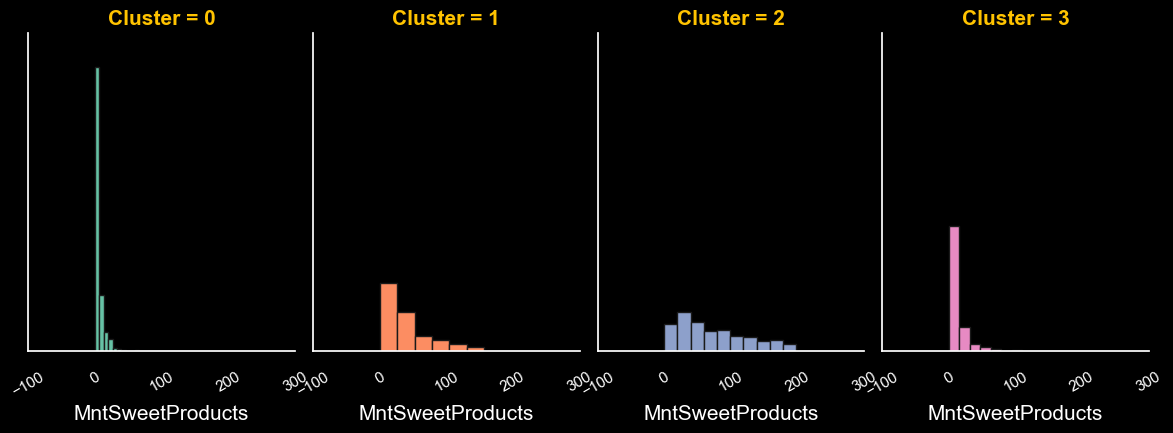

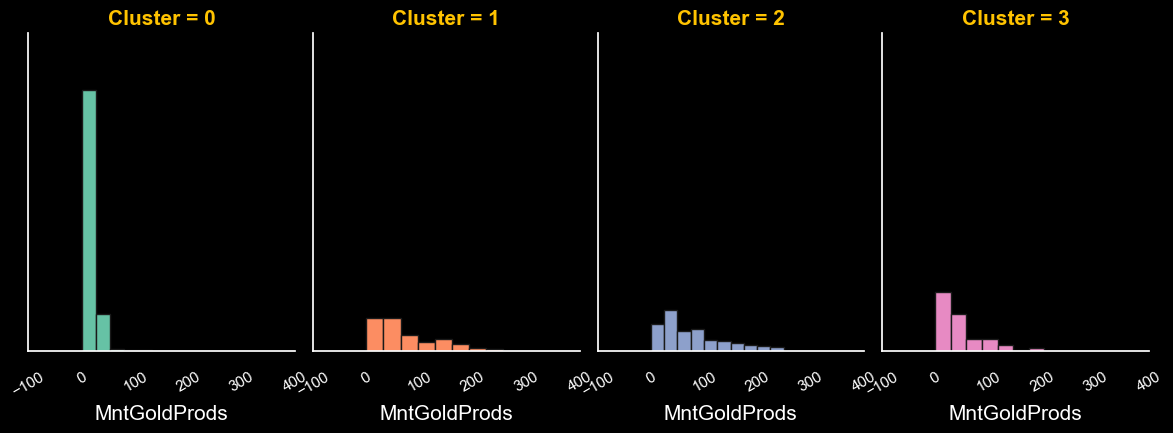

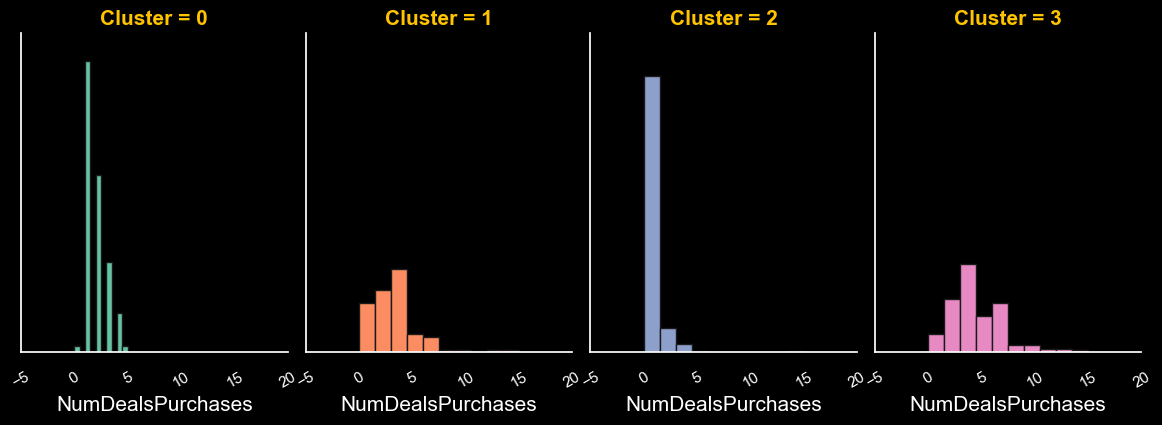

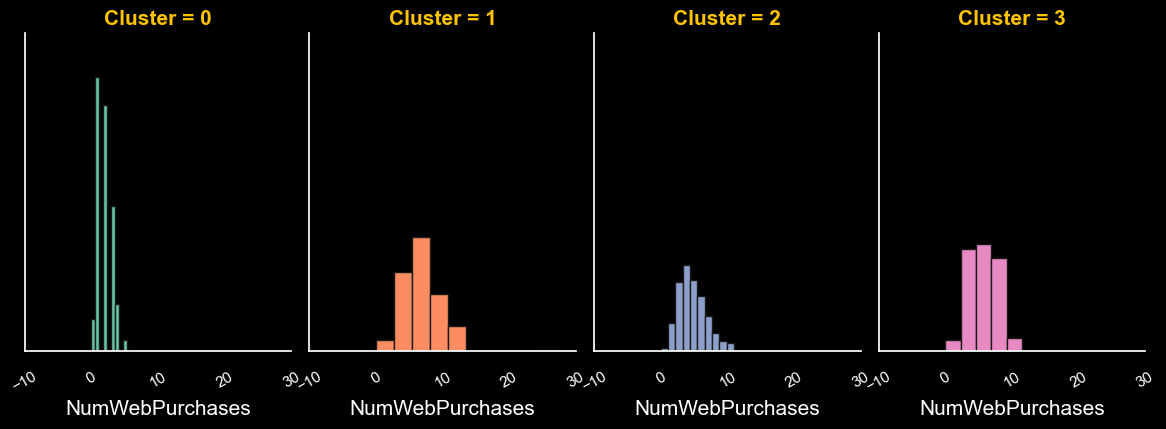

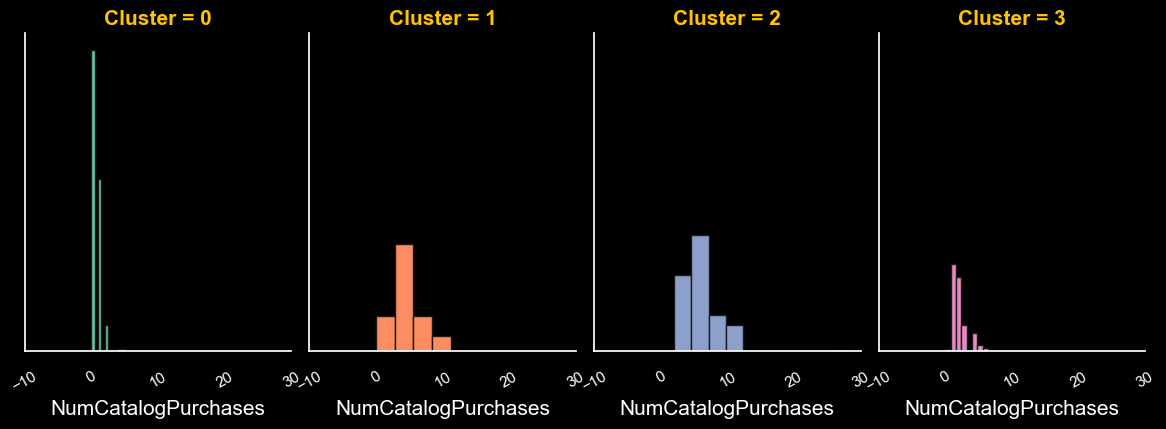

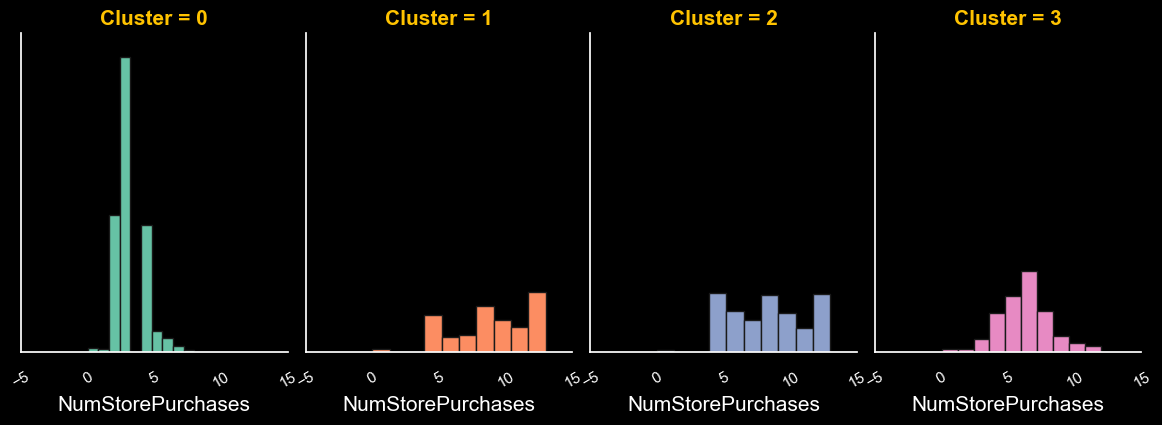

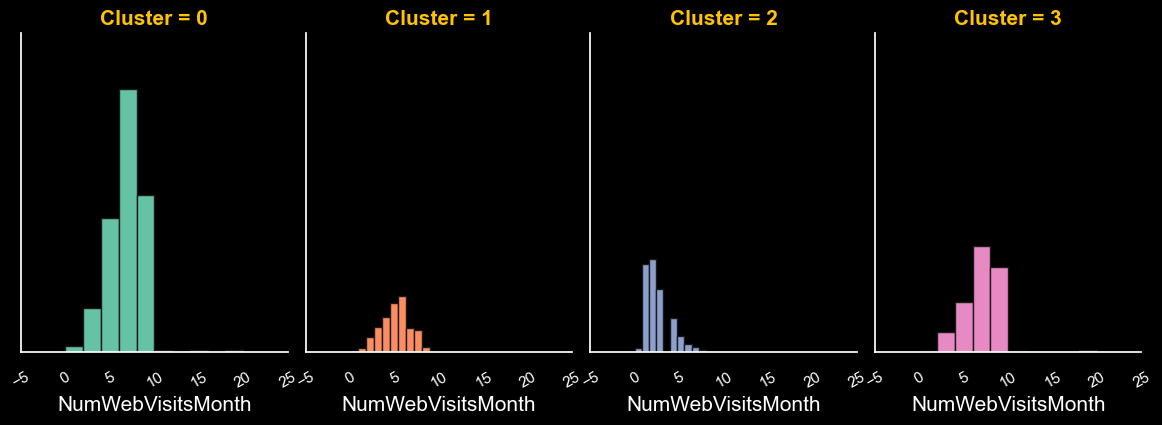

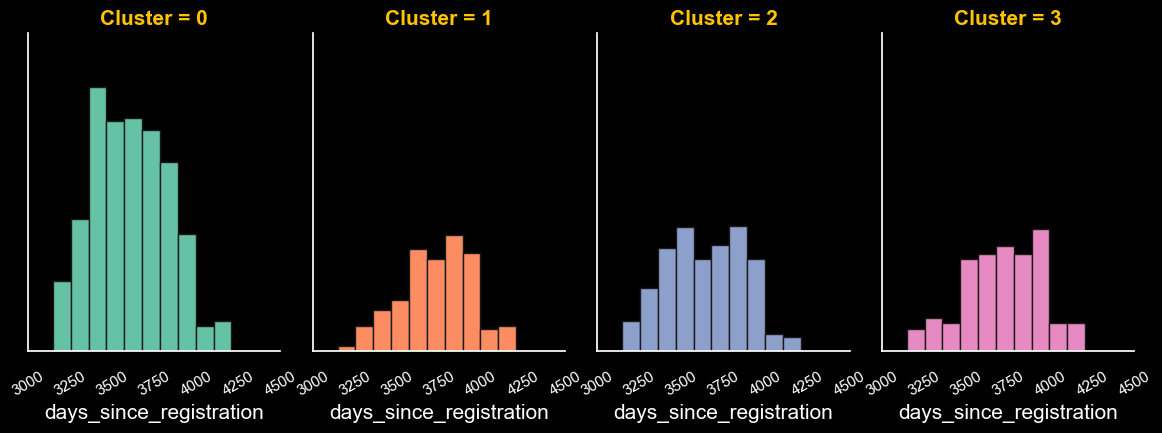

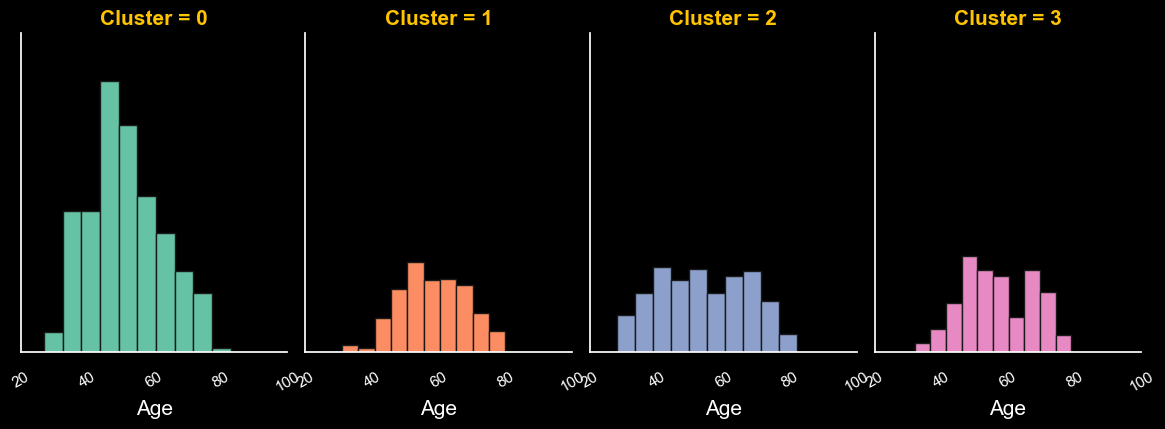

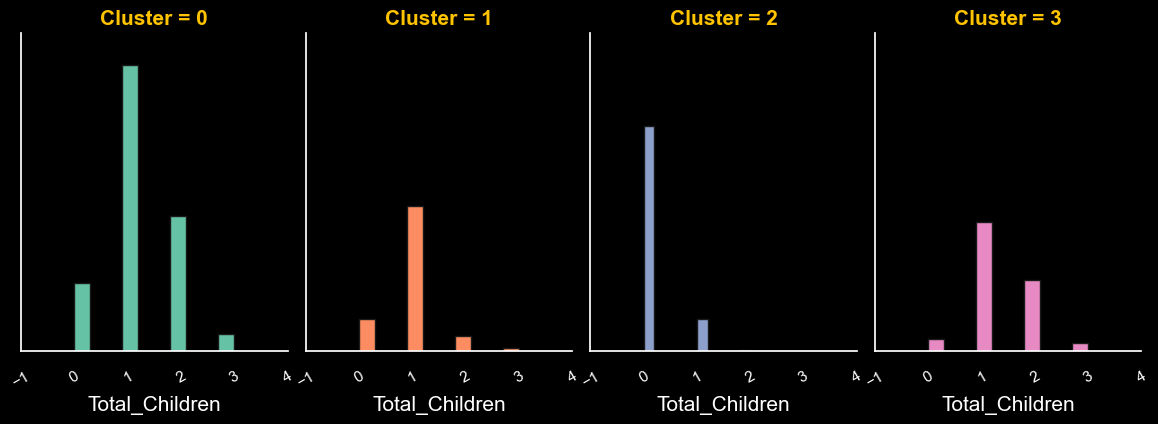

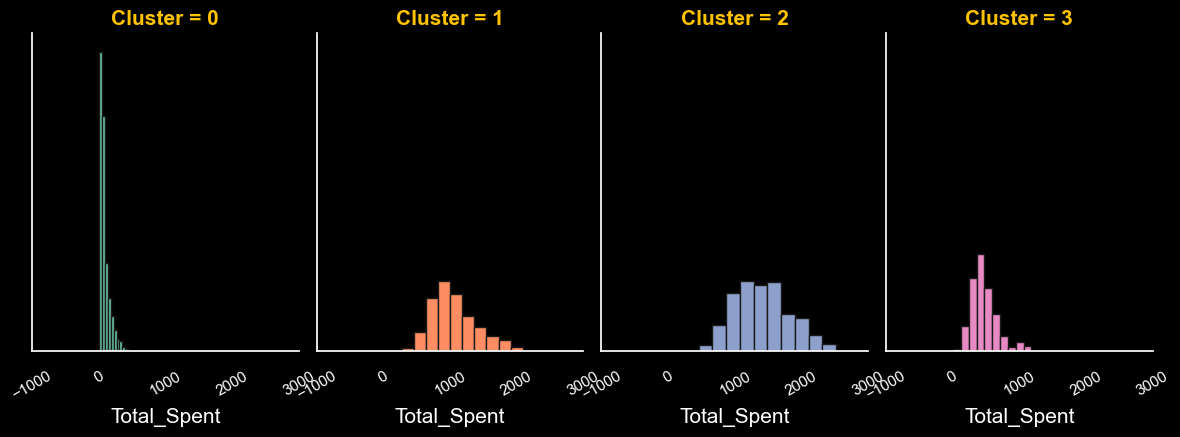

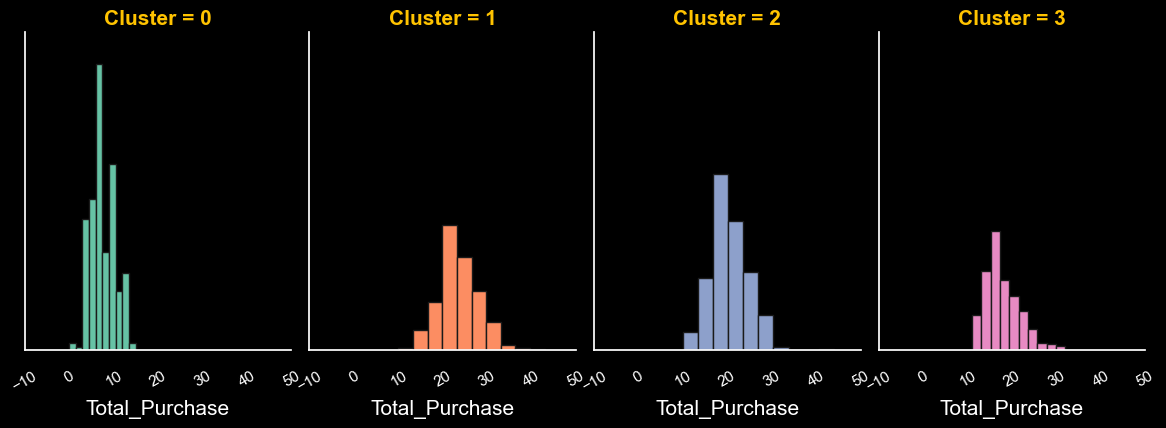

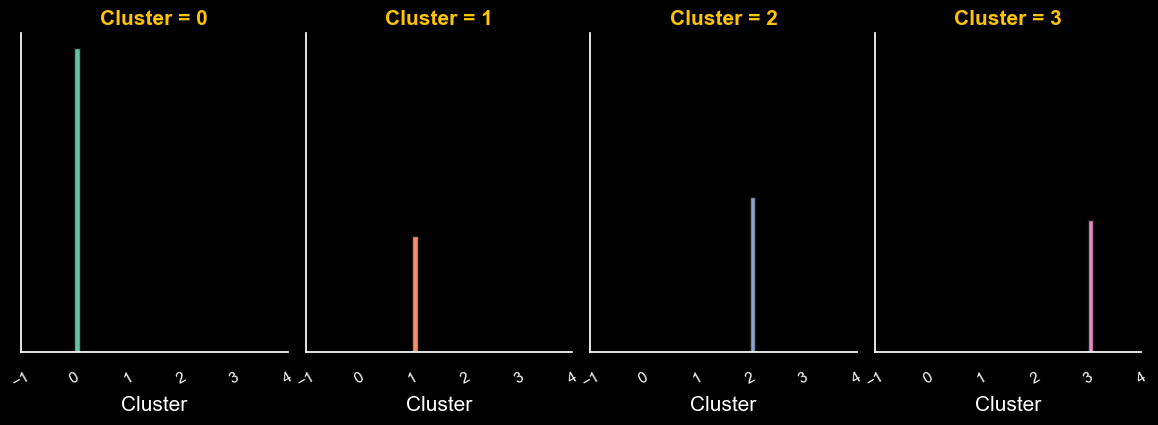

In [43]:
# Clusters interpretation kmeans
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering KMeans**
Cluster 0:
- Pendapatan rendah
- Paling jarang membeli produk
- Mayoritas adalah orang yang lebih muda

Cluster 1:
- Pendapatan menengah
- Menghabiskan banyak uang ketika belanja
- Mayoritas memiliki 1 anak
- Sering membeli wine

Cluster 2:
- Pendapatan tinggi
- Mayoritas tidak memiliki anak. Tidak ada yang memiliki lebih dari 1 anak.
- Suka membeli bermacam-macam produk
- Tidak menunggu diskon ketika membeli barang

Cluster 3:
- Pendapatan menengah
- Hemat dalam berbelanja
- Hampir semuanya memiliki anak

### **Agglomerative Clustering**

Elbow Method untuk mencari jumlah cluster Agglomerative optimal:


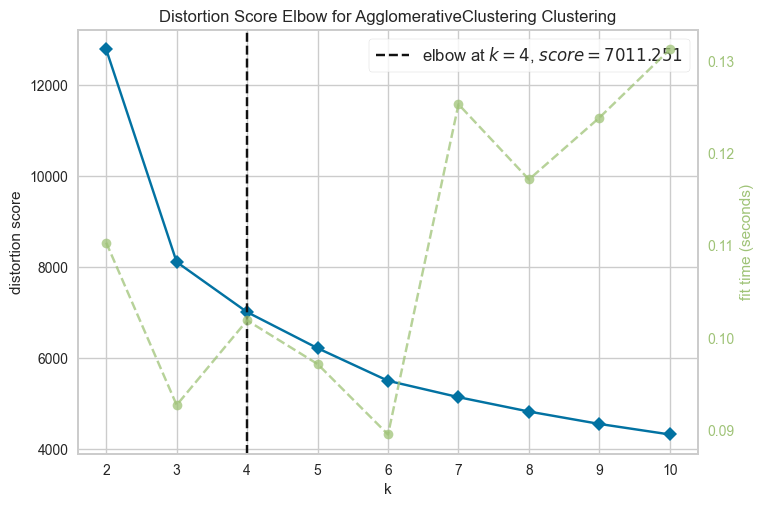

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
# Mencari jumlah cluster paling optimal untuk agglomerative clustering
print('Elbow Method untuk mencari jumlah cluster Agglomerative optimal:')
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10)
Elbow_M.fit(df_pca)
Elbow_M.show()

Tampak bahwa paling optimal adalah 4 cluster

In [42]:
ac = AgglomerativeClustering(n_clusters=4)
ac = ac.fit_predict(df_pca)

df['Cluster'] = ac

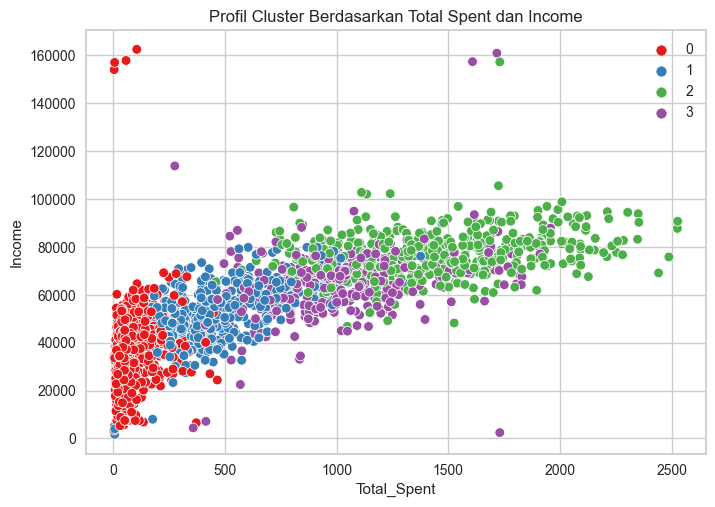

In [43]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

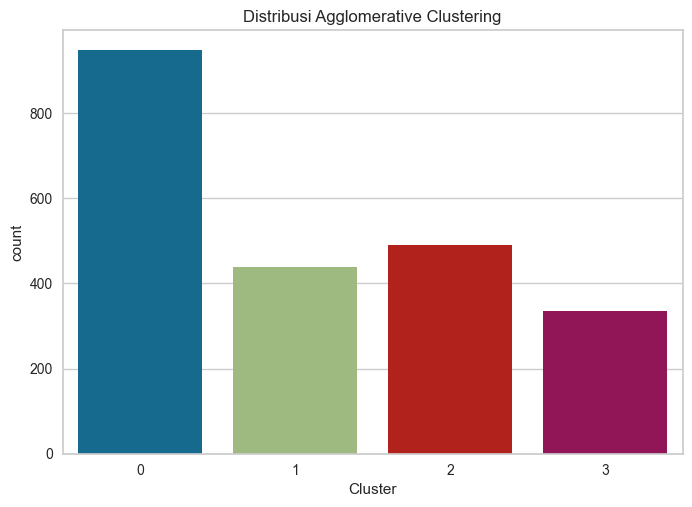

In [44]:
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi Agglomerative Clustering")
plt.show()

c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  

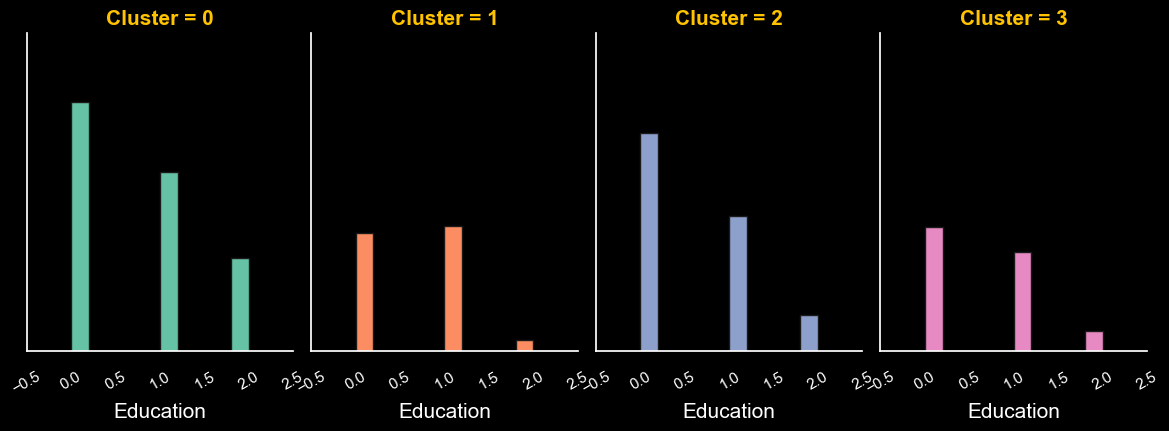

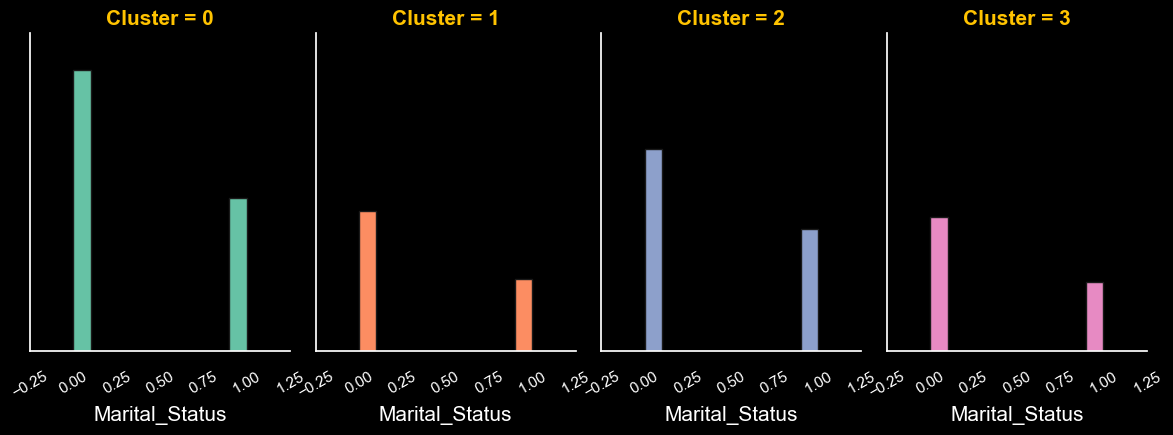

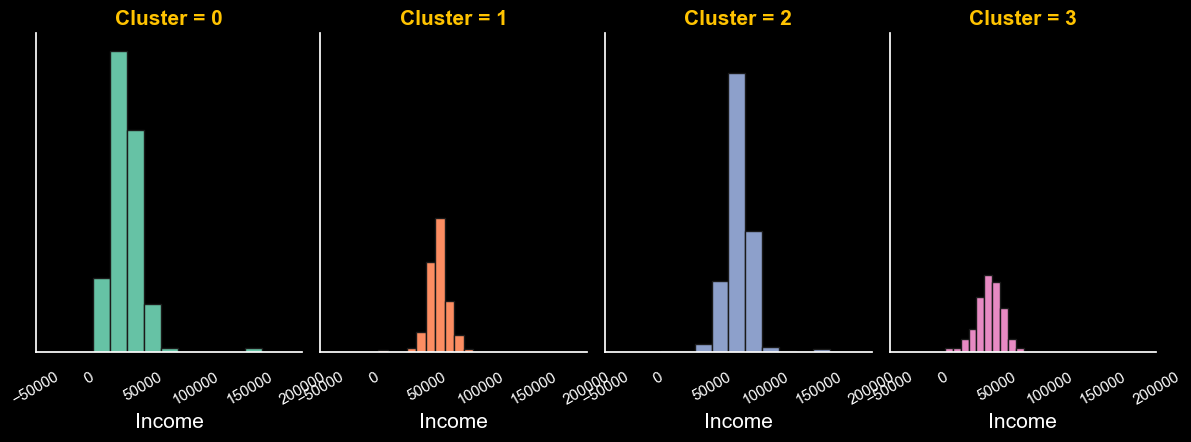

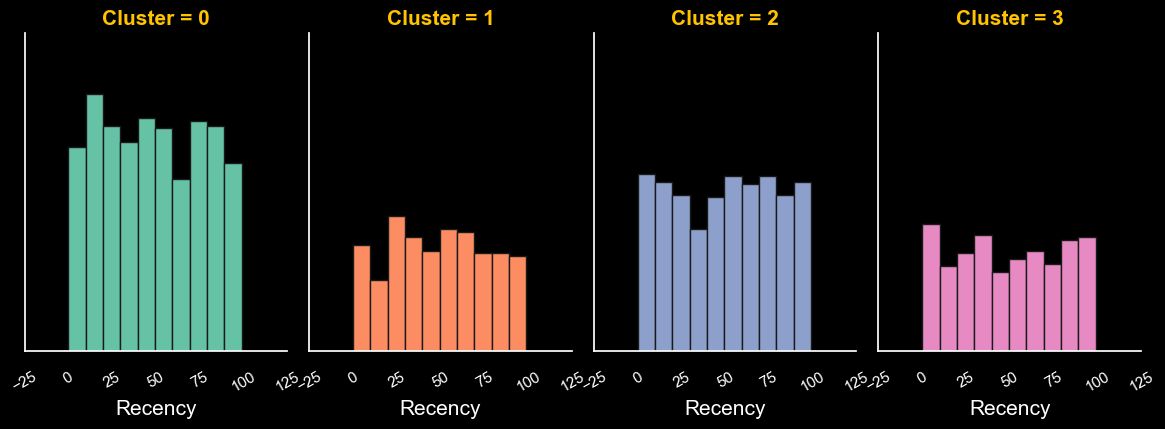

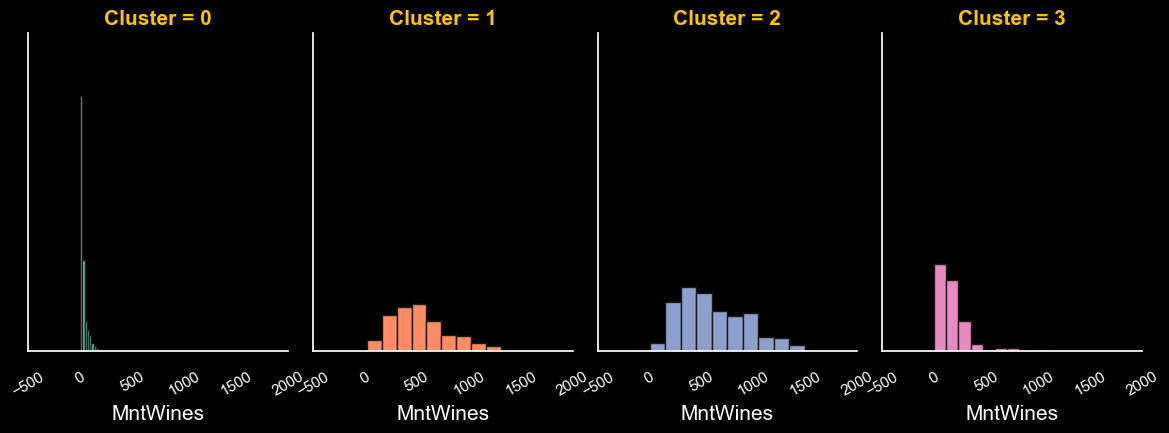

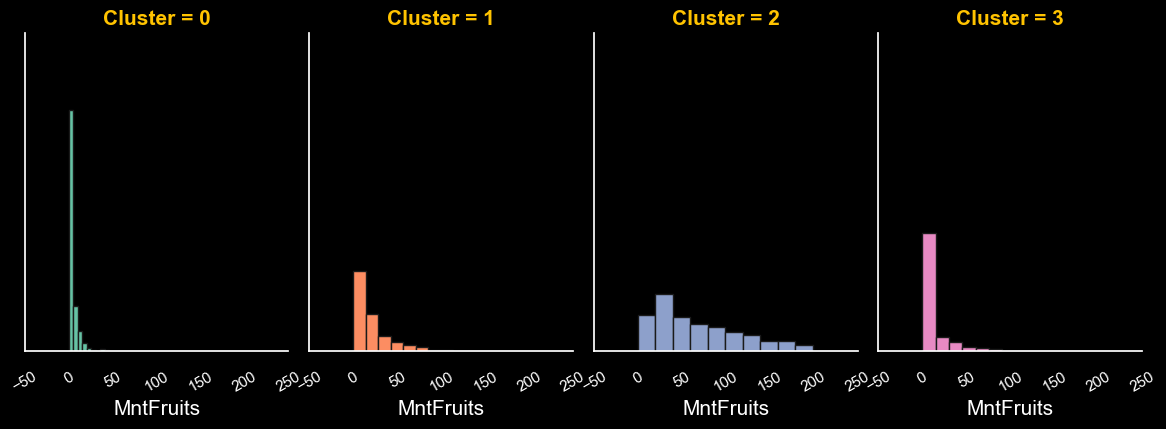

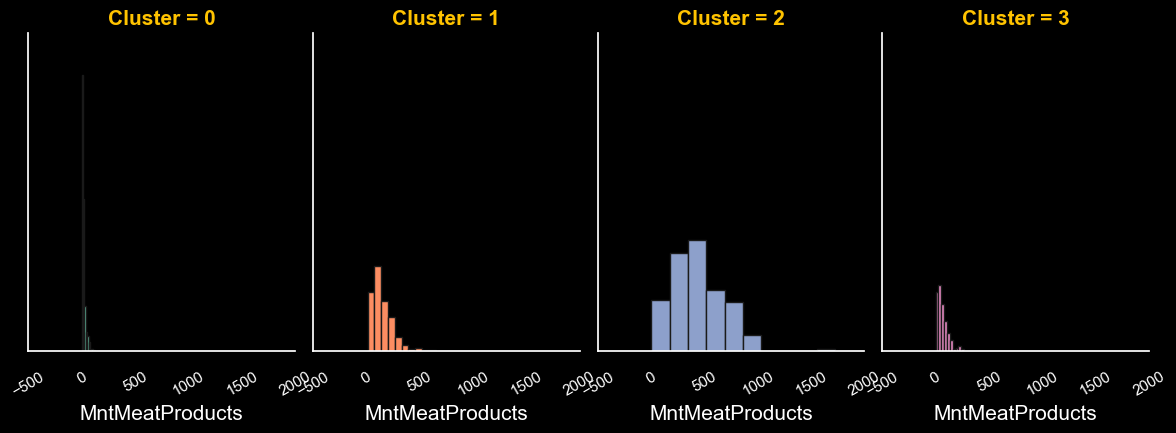

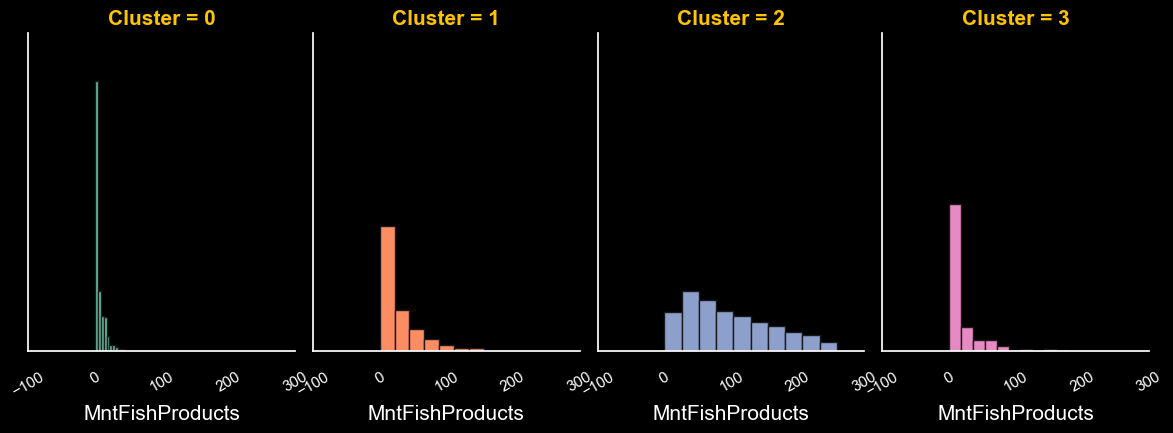

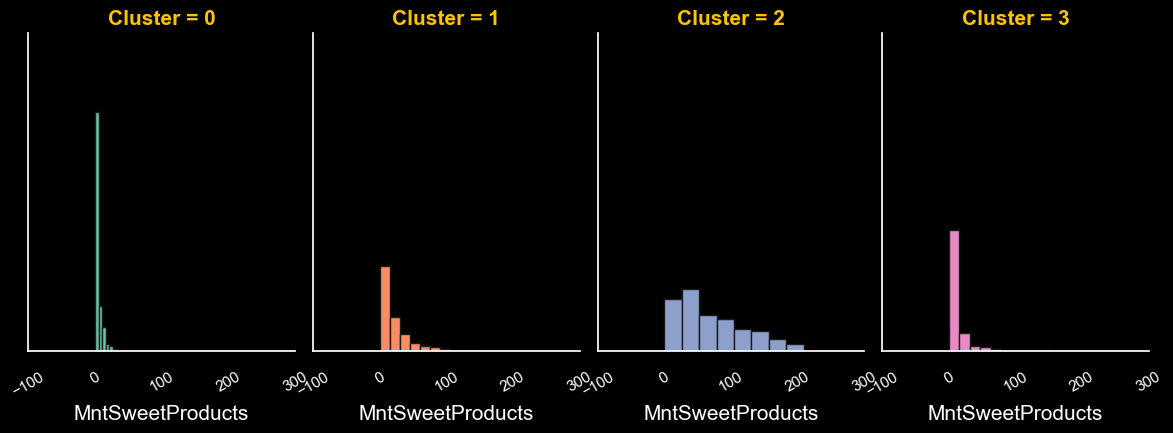

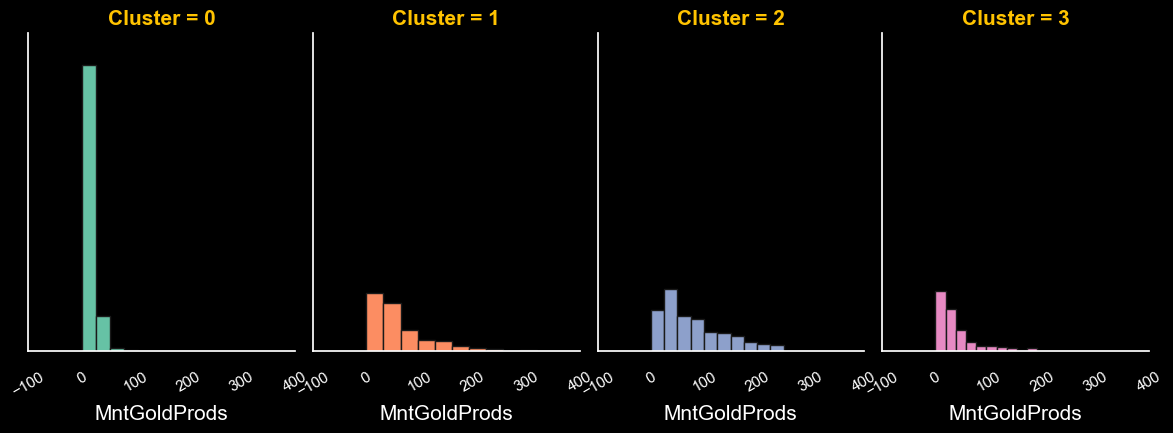

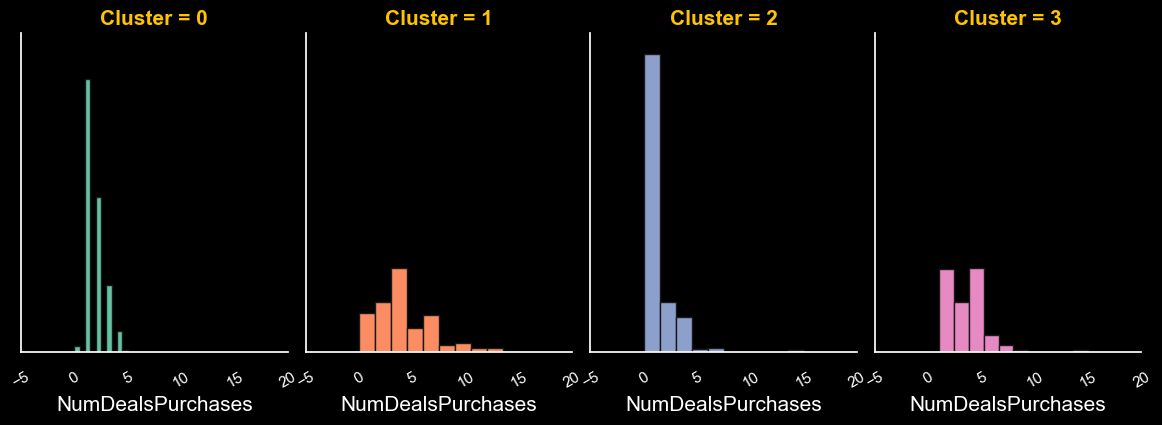

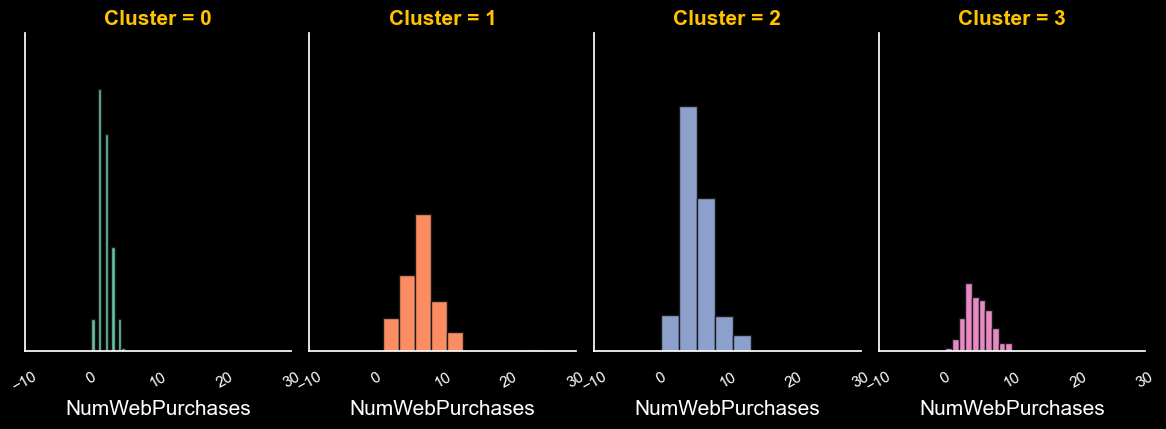

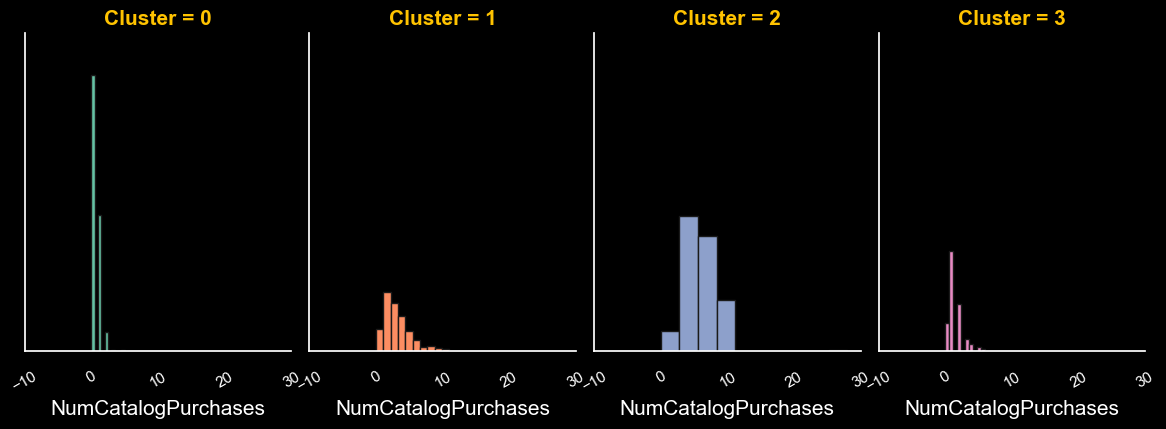

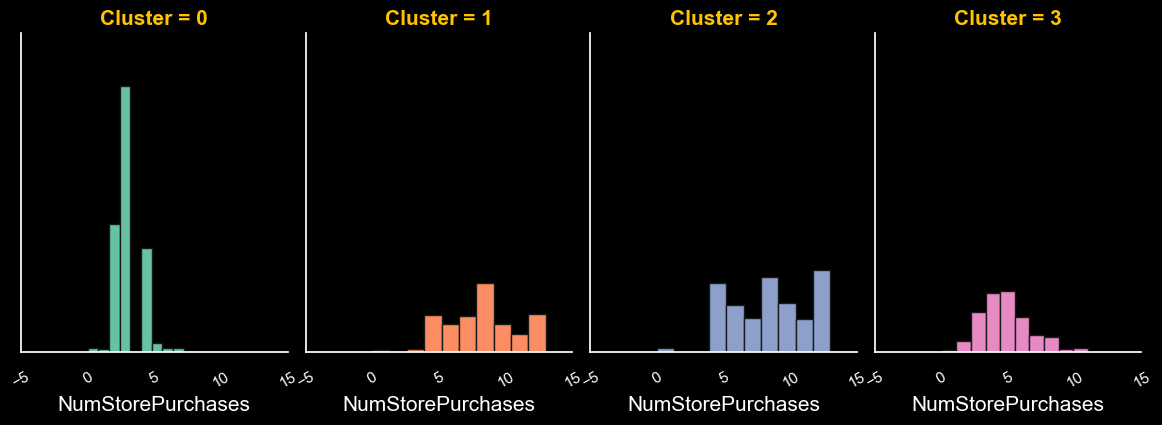

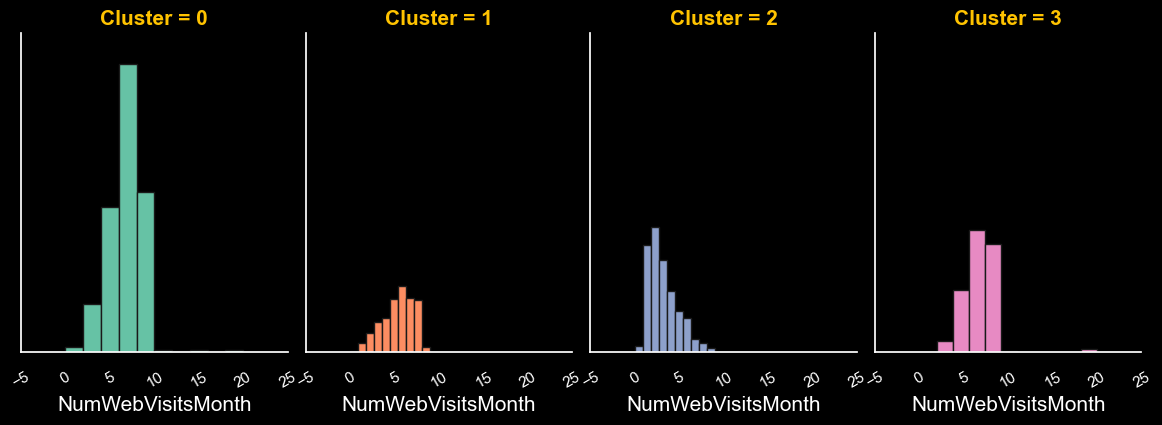

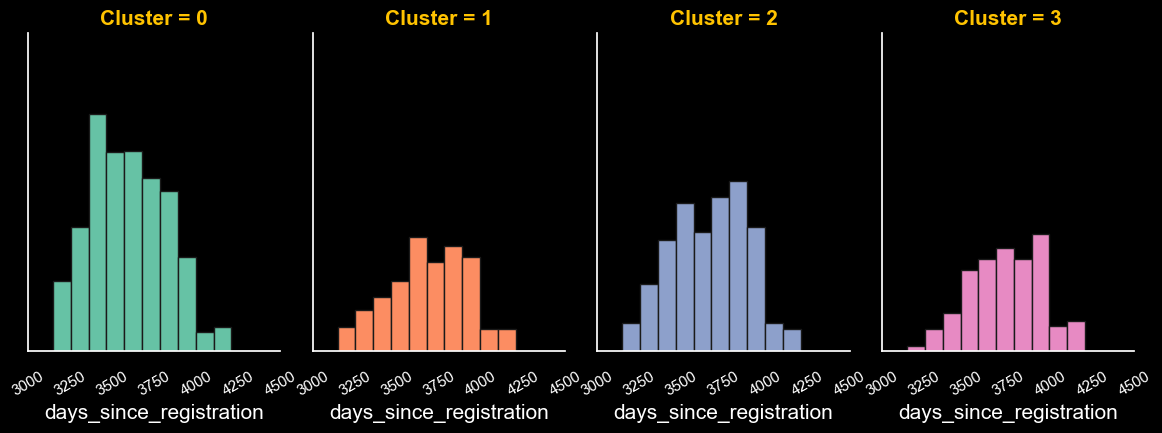

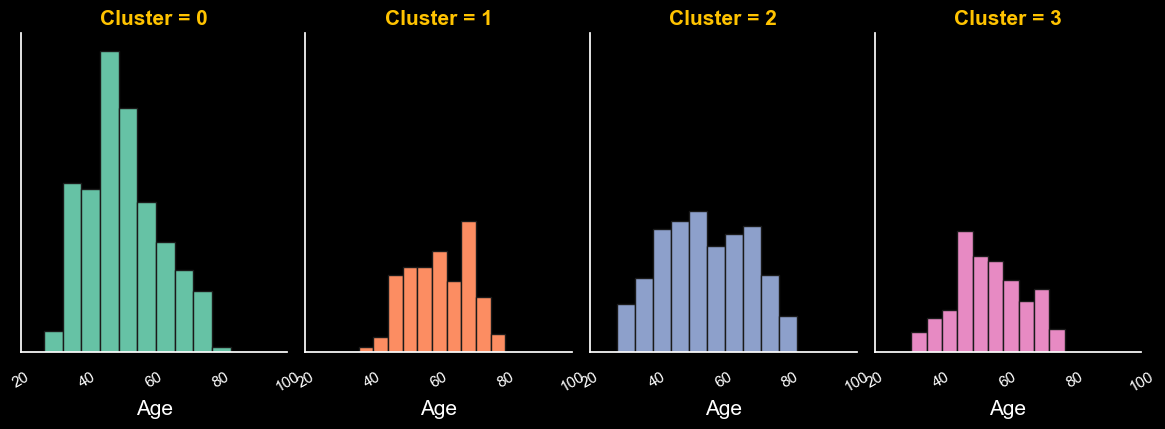

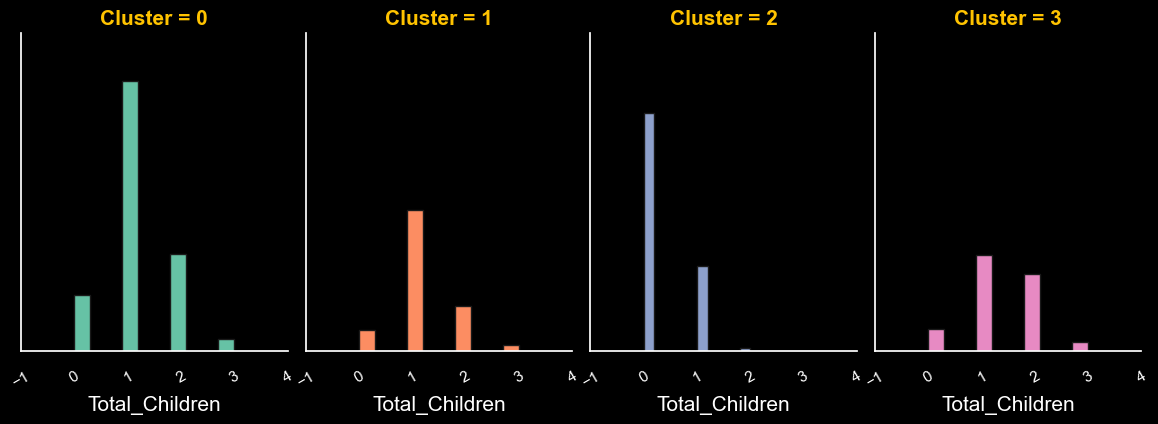

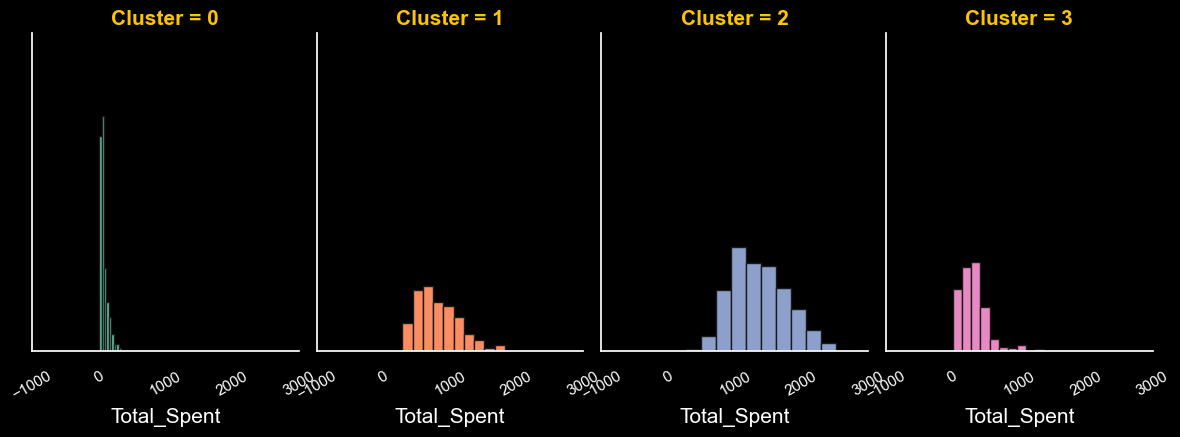

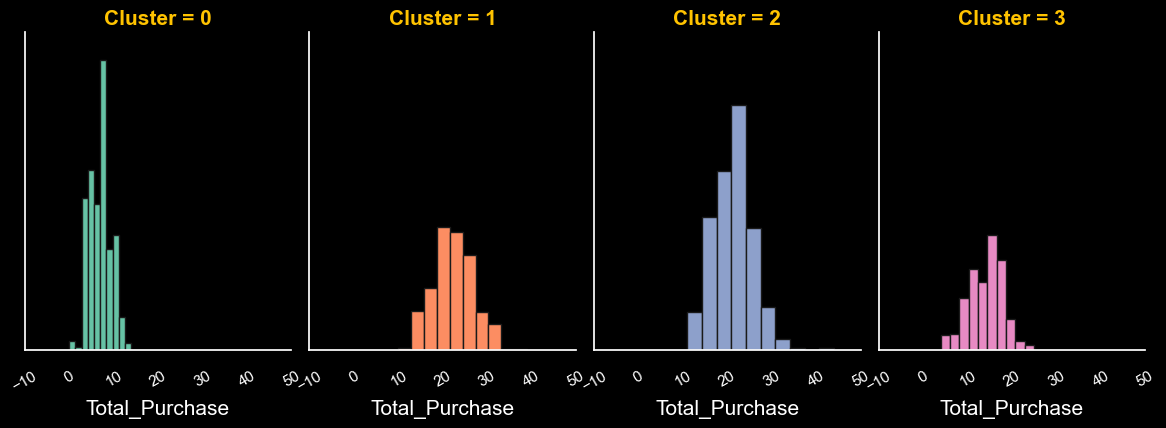

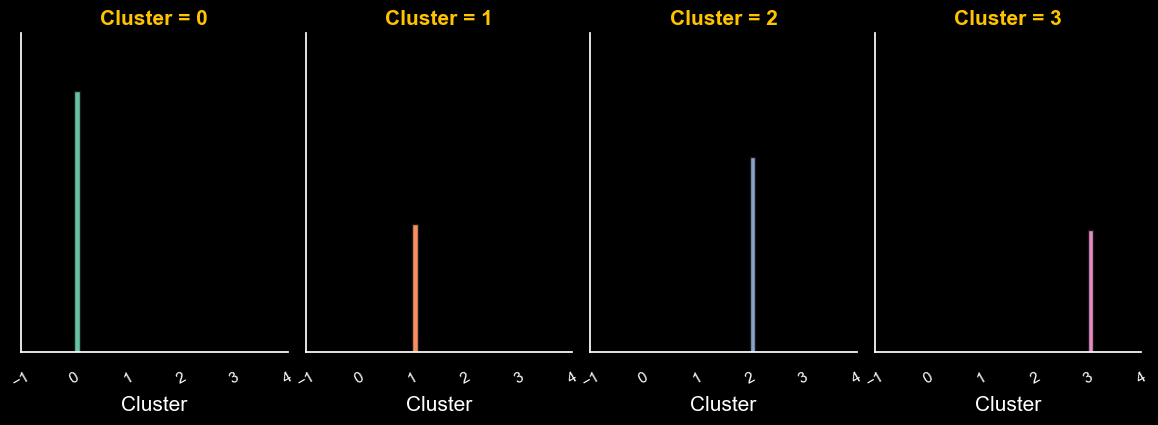

In [43]:
# Clusters interpretation ac
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering Agglomerative**
Cluster 0:
- Pendapatan rendah
- Paling jarang membeli produk
- Mayoritas adalah orang dengan usia lebih muda

Cluster 1:
- Pendapatan menengah
- Mayoritas adalah orang dengan usia tua
- Suka membeli wine dan meat
- Suka menunggu diskon ketika membeli barang

Cluster 2:
- Pendapatan tinggi
- Paling banyak mengeluarkan uang untuk belanja
- Mayoritas tidak memiliki anak. Jika memiliki anak, maka ia hanya memiliki 1 anak saja.
- Suka membeli bermacam-macam produk
- Tidak menunggu diskon saat membeli produk

Cluster 3:
- Pendapatan rendah
- Menghabiskan lebih banyak uang untuk membeli barang dibandingkan cluster 0
- Lebih banyak membeli produk dibandingkan cluster 0

### **Birch Clustering**

In [117]:
birch = Birch(n_clusters=4, threshold=0.01)
birch = birch.fit_predict(df_pca)

df['Cluster'] = birch

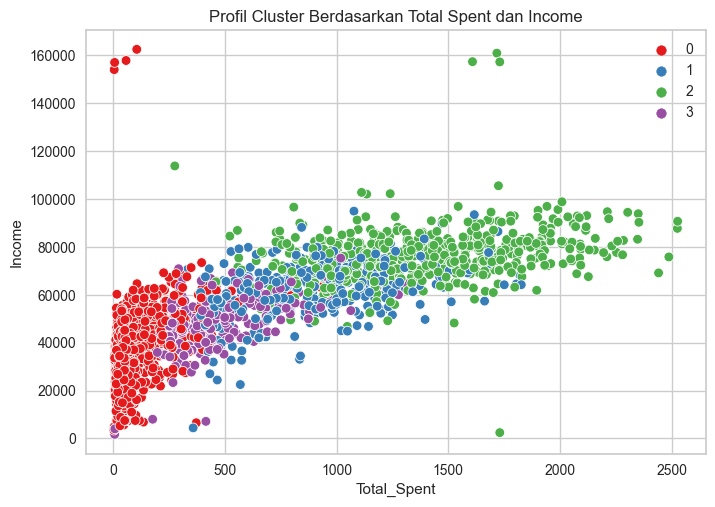

In [118]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

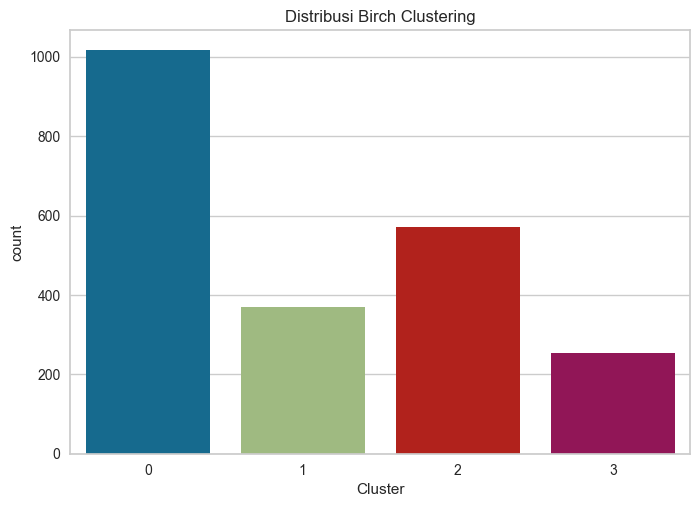

In [119]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi Birch Clustering")
plt.show()

c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  

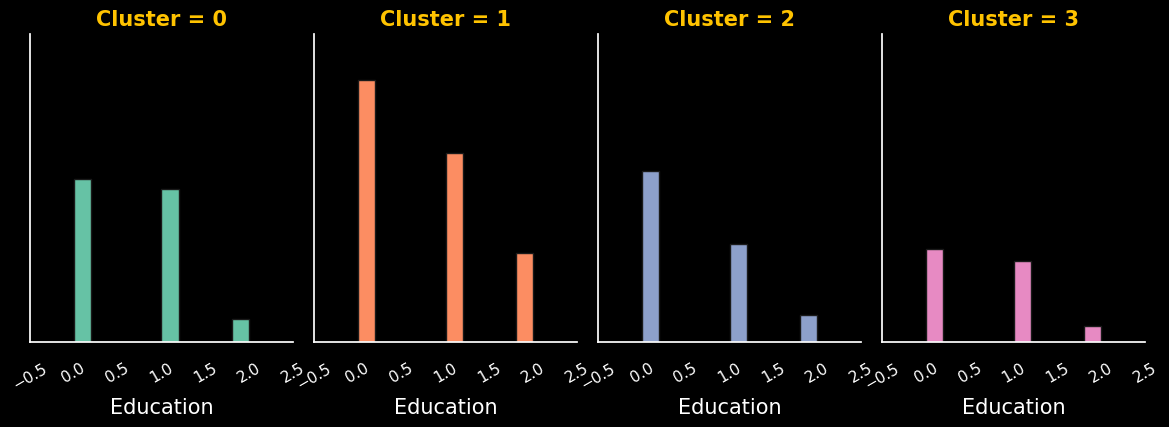

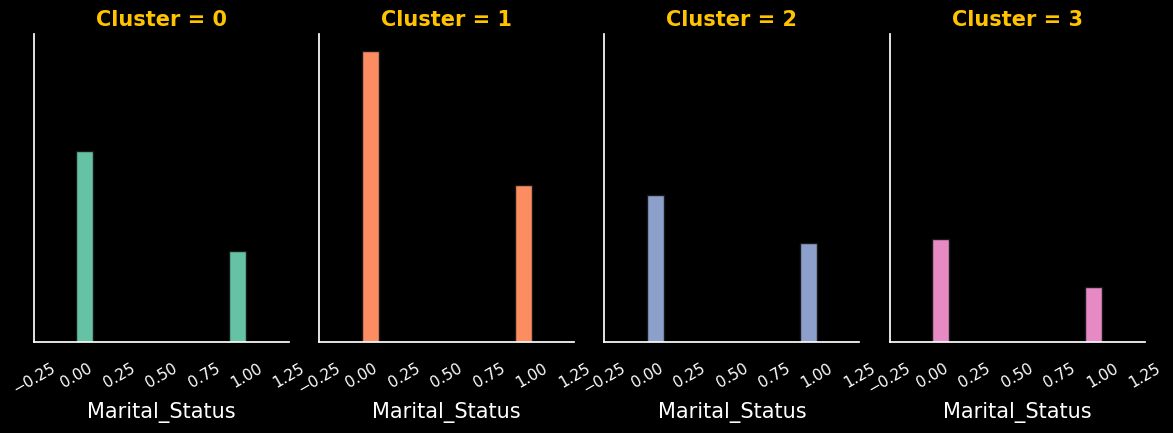

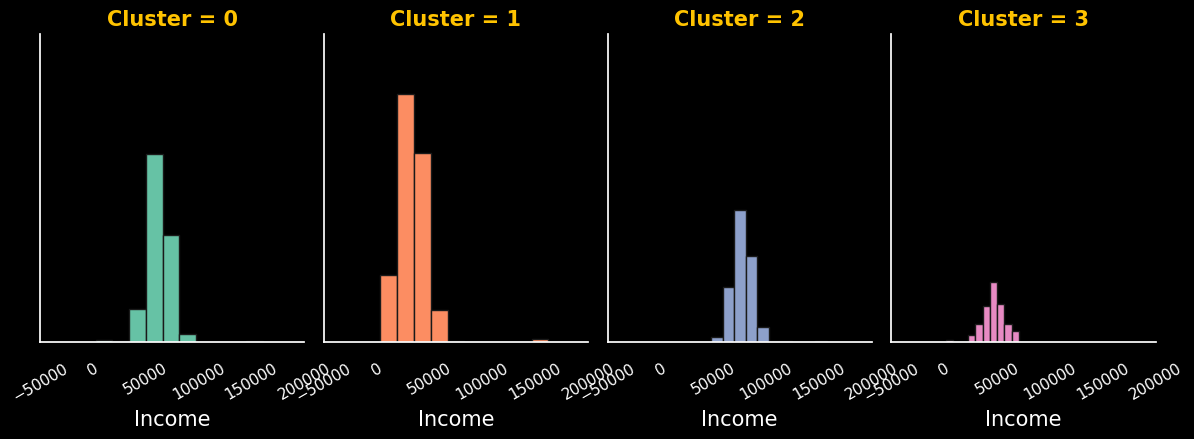

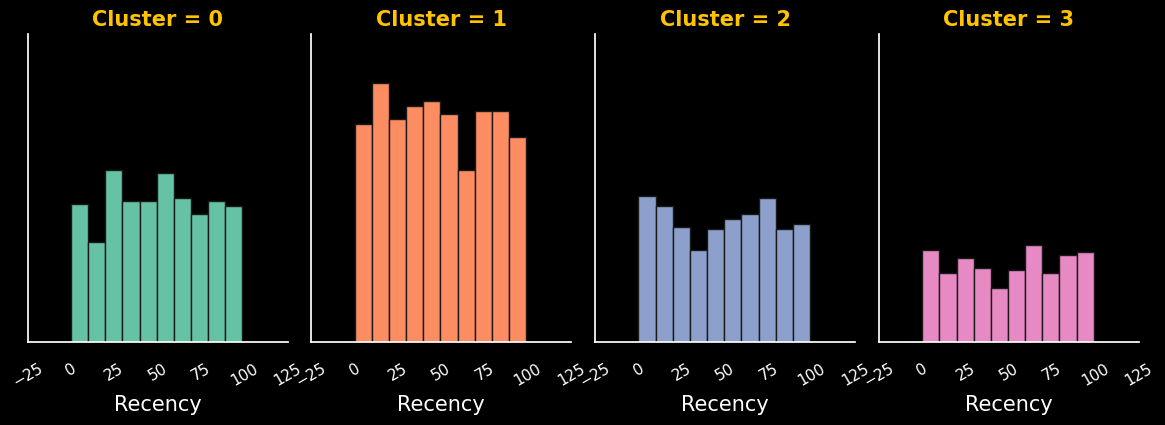

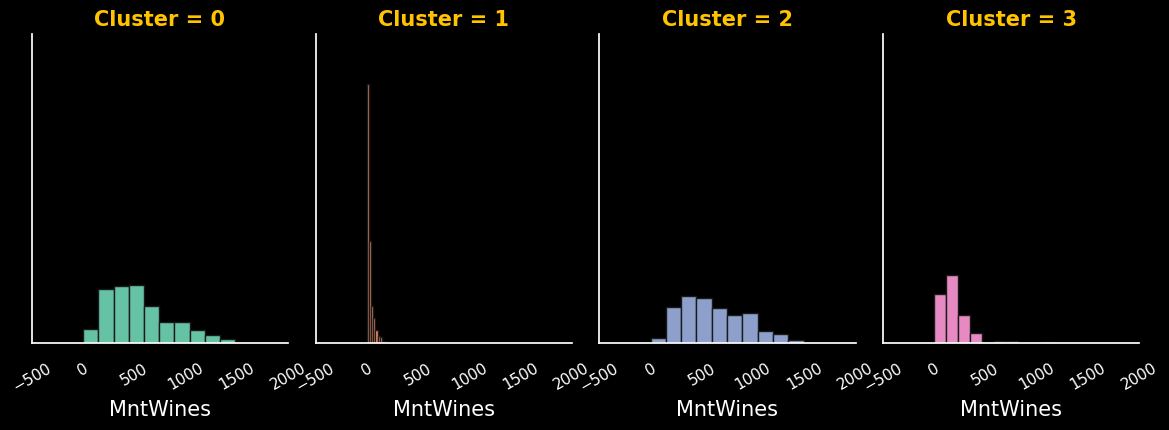

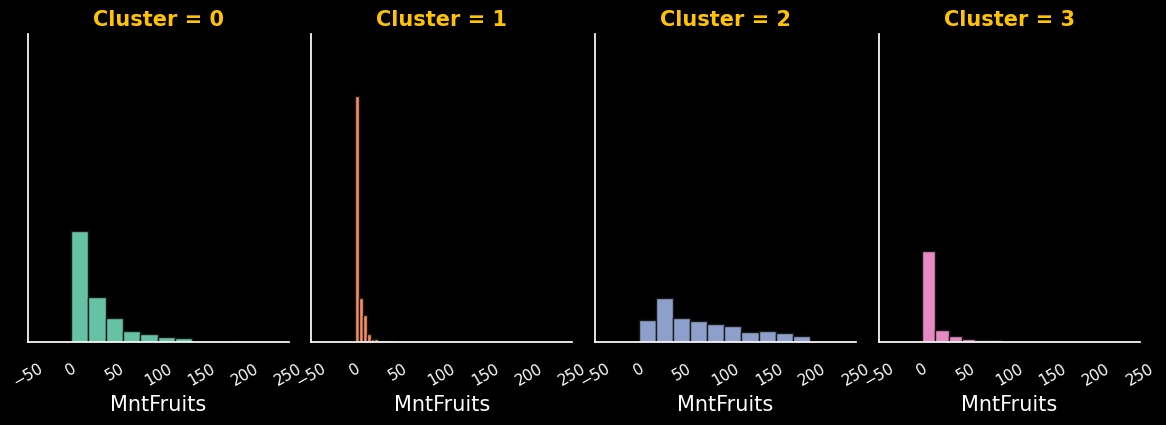

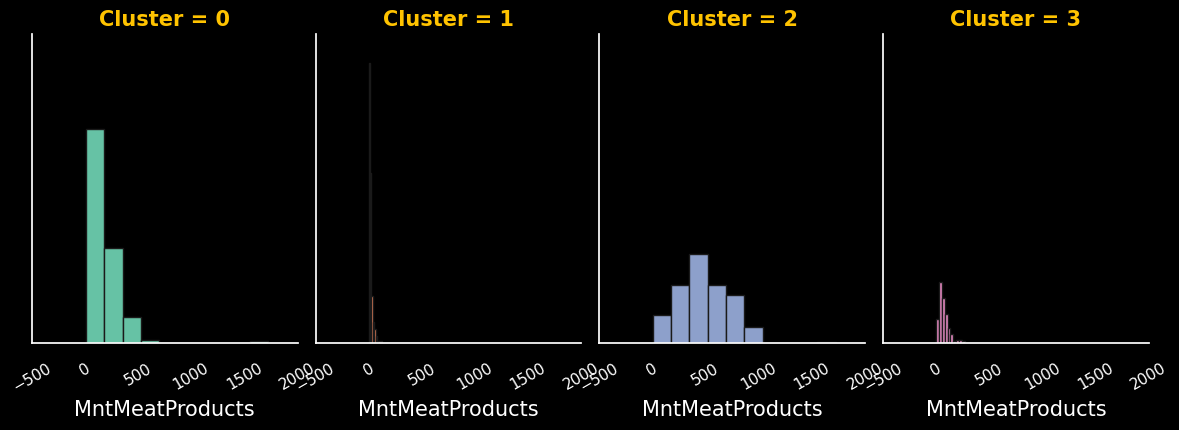

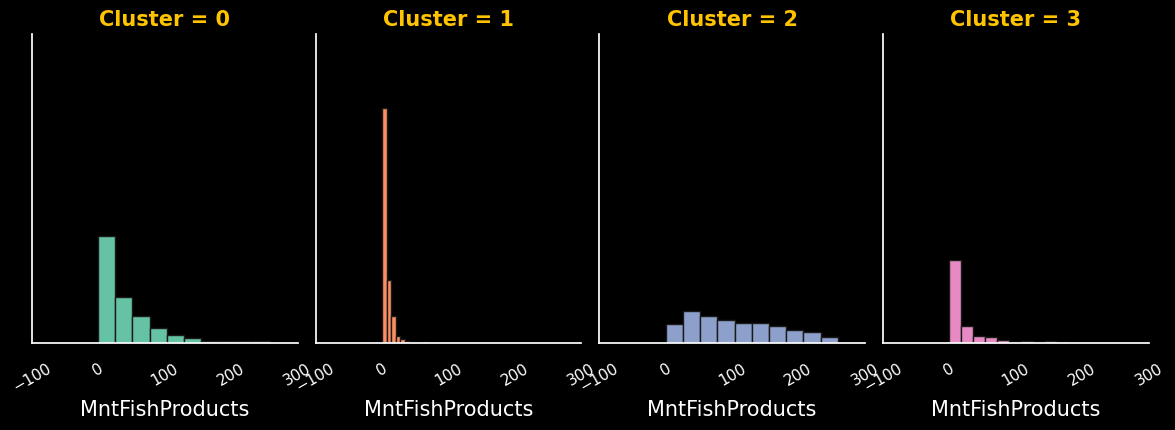

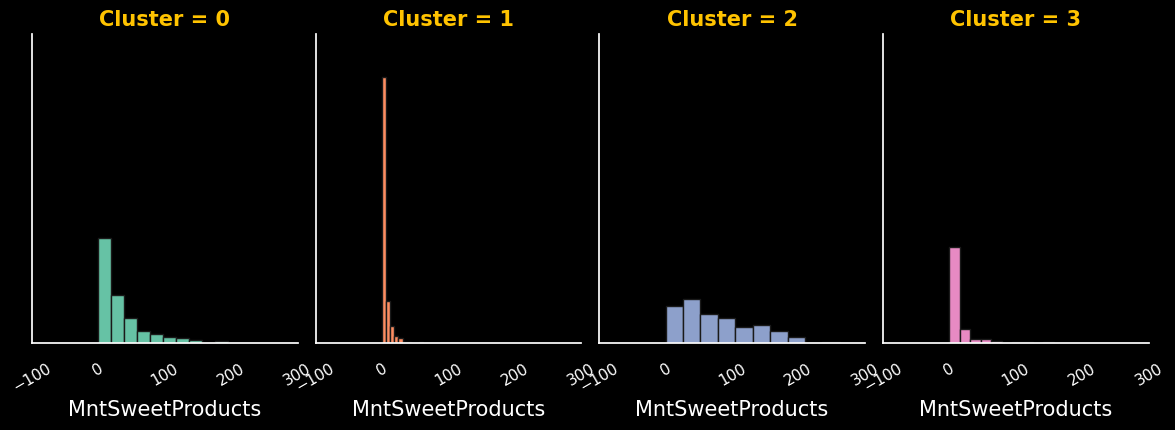

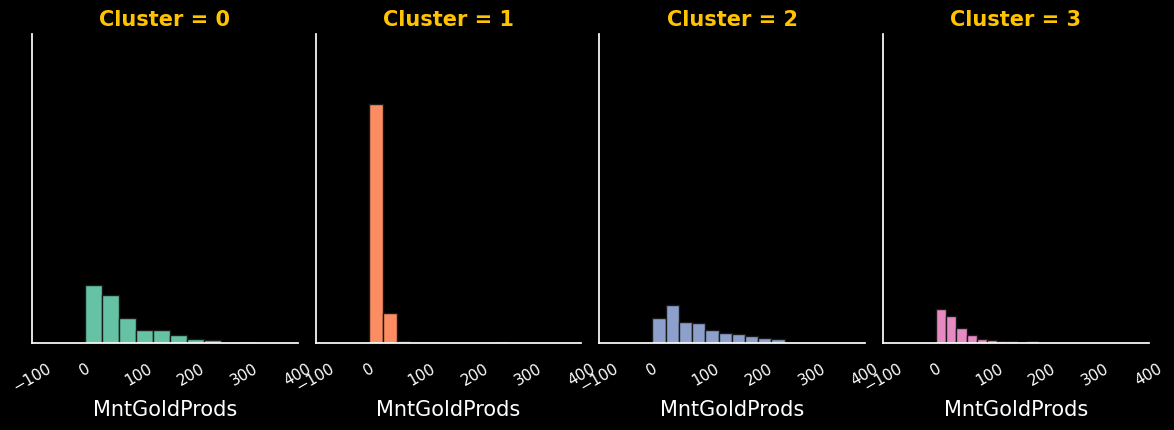

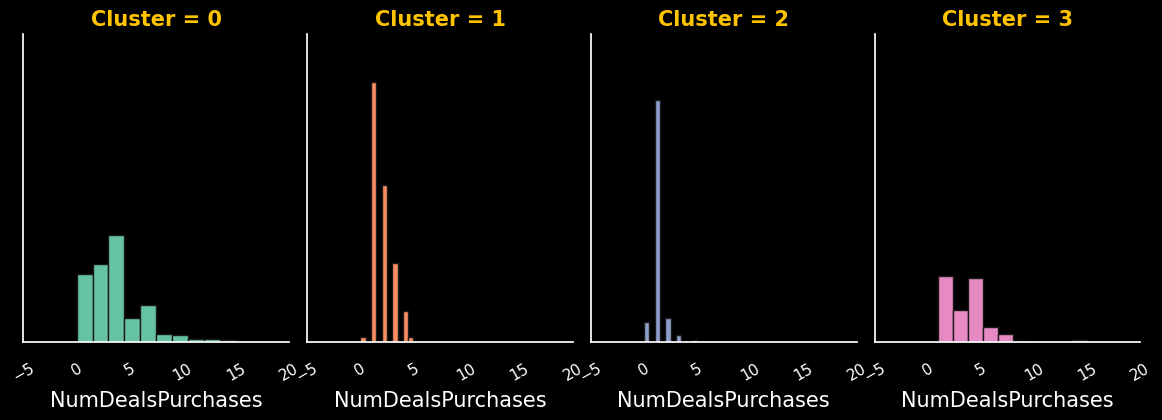

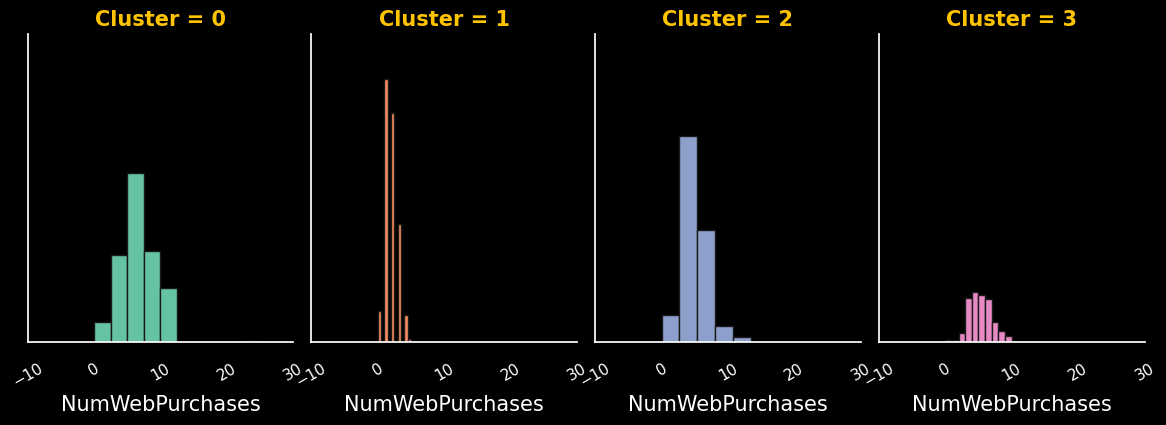

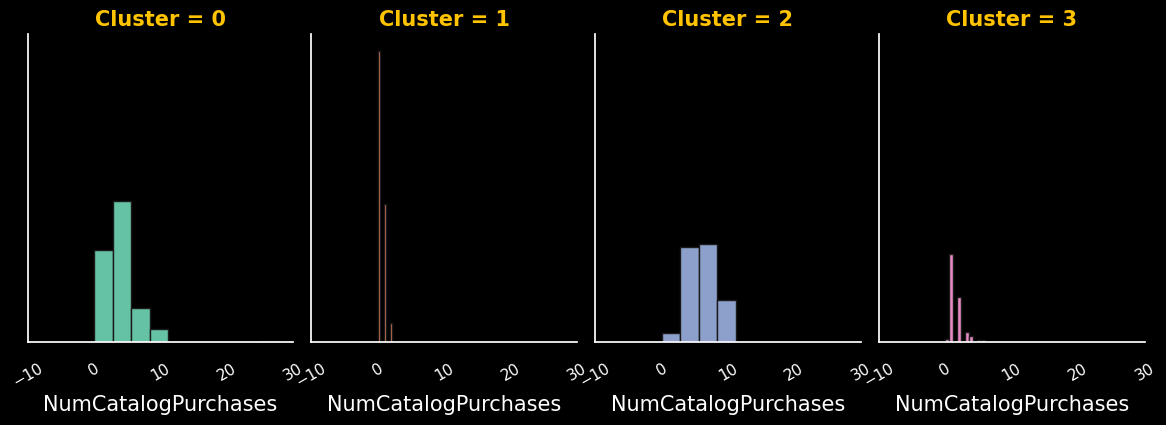

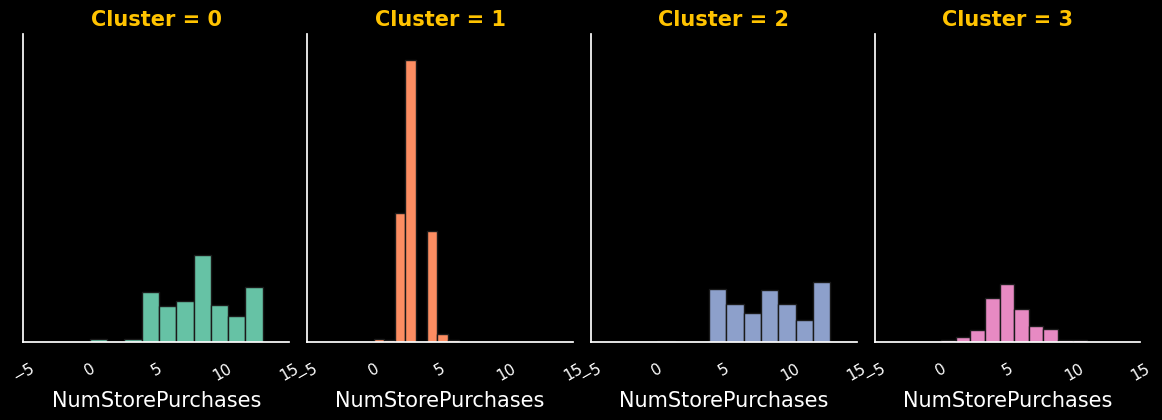

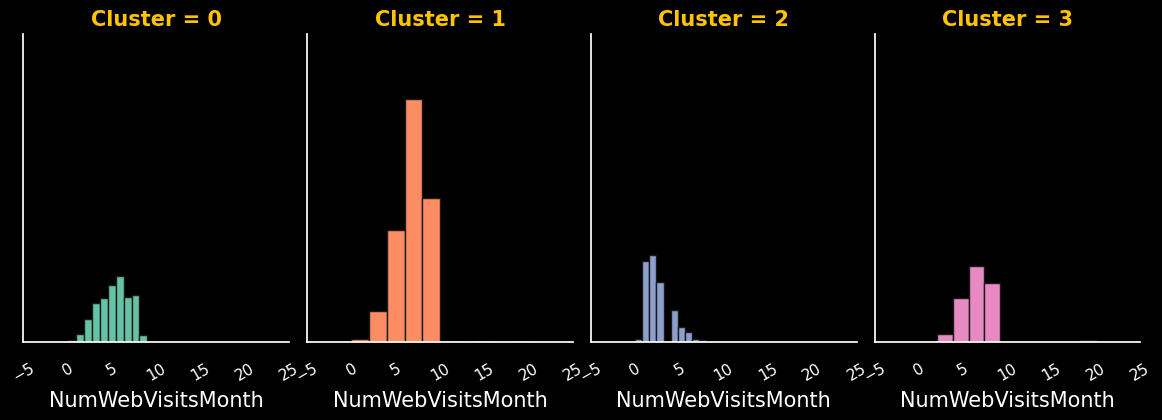

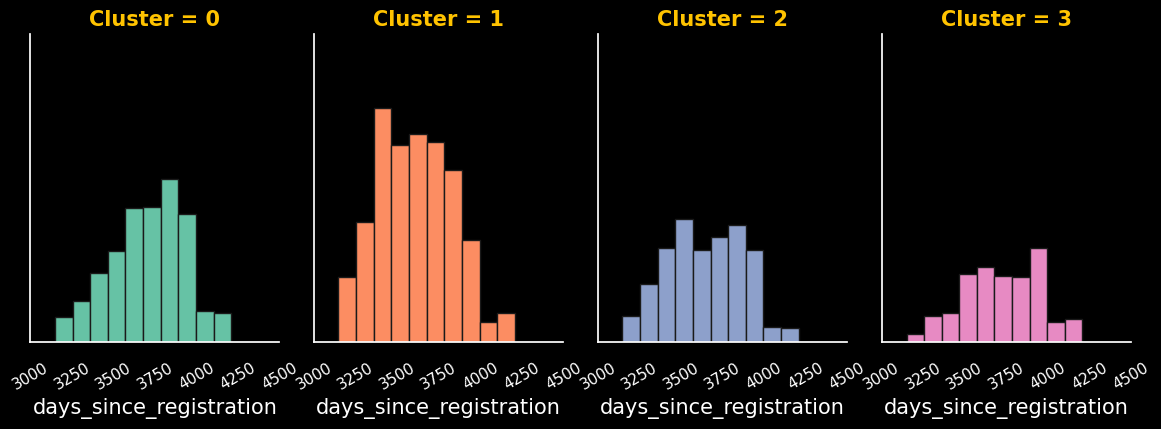

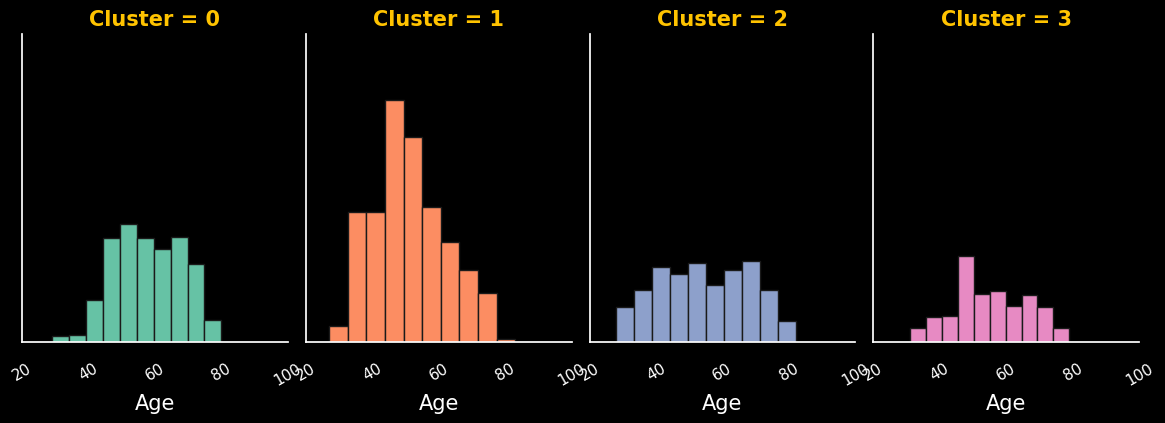

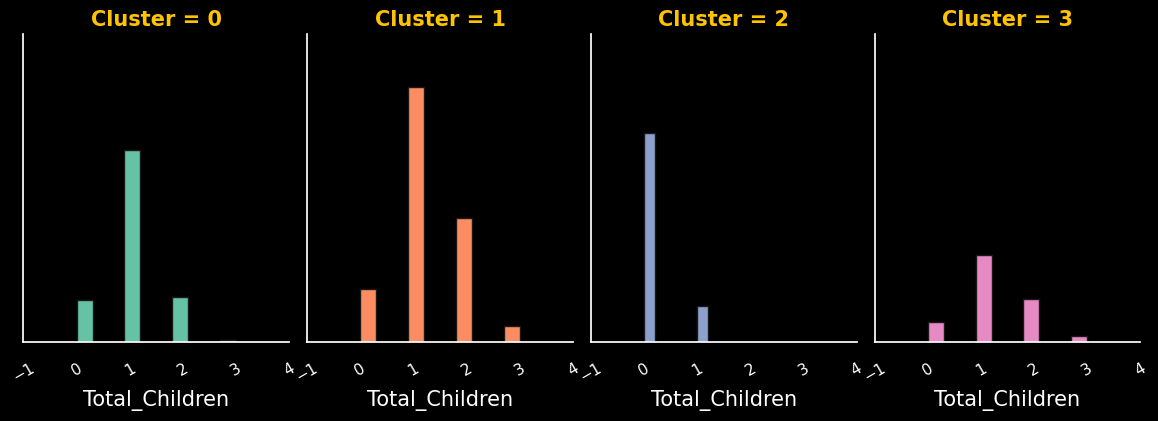

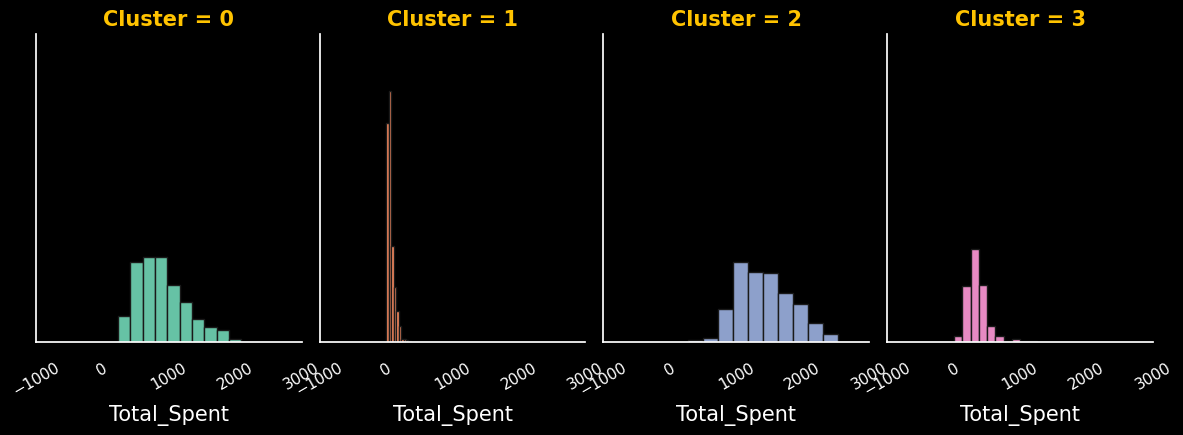

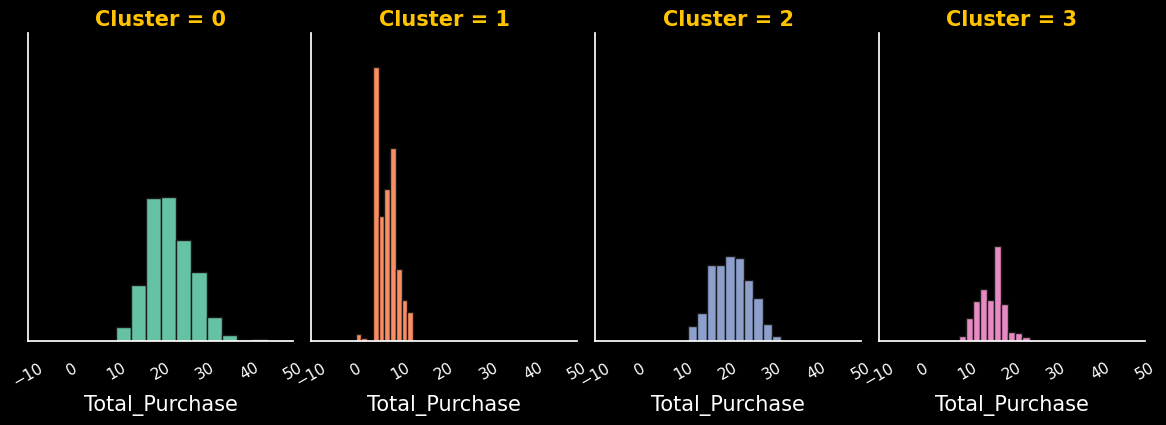

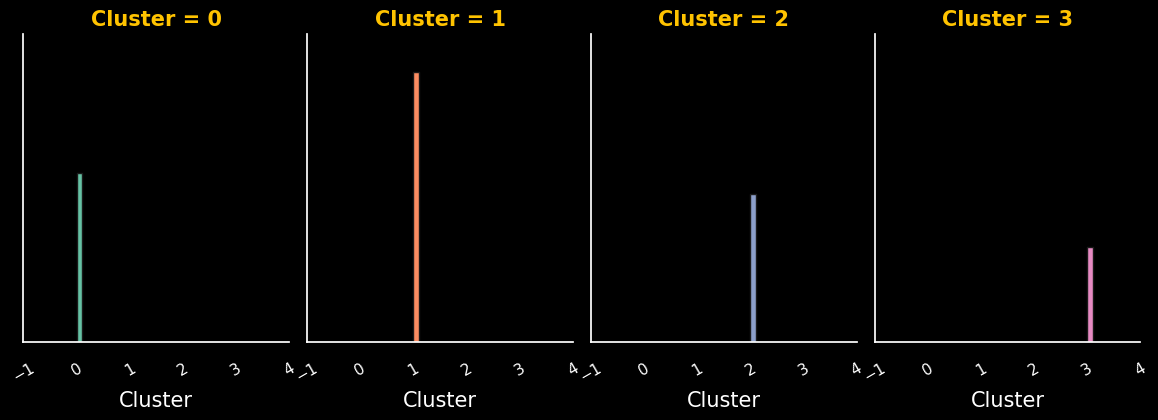

In [147]:
# Clusters interpretation birch
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering Birch**
Cluster 0:
- Pendapatan menengah
- Menghabiskan banyak uang untuk membeli produk
- Maksimal memiliki 2 anak
- Lebih suka membeli wine dibandingkan cluster 3

Cluster 1:
- Pendapatan rendah
- Paling jarang membeli produk

Cluster 2:
- Pendapatan tinggi
- Paling banyak menghabiskan uang untuk membeli produk
- Mayoritas tidak memiliki anak. Jika memiliki anak, maka ia hanya memiliki 1 anak saja.
- Suka membeli barang via katalog
- Suka membeli bermacam-macam produk
- Tidak menunggu diskon untuk membeli barang

Cluster 3:
- Pendapatan menengah
- Hemat dalam membeli produk
- Hampir semuanya memiliki anak